# Packages & libraries

We report below all the necessary packages and libraries.

In [372]:
# standard libraries
# - dataframes
import pandas as pd
# - numpy
import numpy as np
# - plot libraries (and settings)
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import seaborn as sns
sns.set(font = "serif", style = "whitegrid", palette = "dark:#5A9_r", font_scale = 0.75)

# ml
# - standard ml tools
from statsmodels.compat import lzip
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# - linear regressions
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# - dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.cross_decomposition  import PLSRegression
# - regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# - poly regressions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# - smoothing splines
from pygam import LinearGAM, s
from functools import reduce
# - decision tree
from sklearn.tree import DecisionTreeRegressor
# - random forests
from sklearn.ensemble import RandomForestRegressor
# - gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
# - svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
# - nn
import torch
import torch.nn as nn
import torch.optim as optim

# Data preprocessing 

Let us first display each dataset and check the number of rows and columns.

In [373]:
sales = pd.read_csv("data/sales.csv")
display(sales)

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,5.5727e+04,NaN
1,WG25,31/12/2022,YES,1.2984e+04,NaN
2,UX72,31/12/2022,YES,1.3047e+04,NaN
3,EE84,31/12/2022,YES,6.0917e+04,NaN
4,RF54,31/12/2022,YES,1.2376e+04,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,2.1554e+04,NaN
523945,WW60,01/01/2021,YES,5.6371e+04,NaN
523946,LU14,01/01/2021,YES,2.4107e+04,NaN
523947,HY57,01/01/2021,YES,1.2257e+04,NaN


In [374]:
n_rows_sales = sales.shape[0]
n_cols_sales = sales.shape[1]
print("- number of rows = " + str(n_rows_sales) + "\n- number of columns = " + str(n_cols_sales))

- number of rows = 523949
- number of columns = 5


In [375]:
market = pd.read_csv("data/market.csv")
display(market)

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,7.7300e+02,515,YES
1,WG25,FRANCE,NaN,MINI,1402,2.5200e+02,522,YES
2,UX72,FRANCE,NaN,MINI,1452,2.6500e+02,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,8.7400e+02,754,YES
4,RF54,FRANCE,NaN,MINI,2497,1.9100e+02,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,3.5600e+02,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,9.0700e+02,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,3.9700e+02,2841,YES
748,HY57,ITALY,NaN,MINI,2495,2.2800e+02,3848,YES


In [376]:
n_rows_market = market.shape[0]
n_cols_market = market.shape[1]
print("- number of rows = " + str(n_rows_market) + "\n- number of columns = " + str(n_cols_market))

- number of rows = 750
- number of columns = 8


The first thing to notice is that both datasets seem to contain a `NaN` column. We will take care of it in the following section together with any possible error.

## Data cleaning

We clean here the datasets separately.

### Sales dataset


We first remove any empty column or row of `sales`.

In [377]:
# remove empty colums
sales = sales.dropna(axis = 1, how = "all")
n_cols_sales = sales.shape[1]

# remove empty rows
sales = sales.dropna(axis = 0, how = "all")
n_rows_sales = sales.shape[0]

print("- number of rows = " + str(n_rows_sales) + "\n- number of columns = " + str(n_cols_sales))

- number of rows = 523948
- number of columns = 4


We now check for `NaN` values: we first count the total number of `NaN` and then display the number of `NaN` values for each column.

In [378]:
n_nan = sales.isnull().sum().sum()
print("- total number of NaN = " + str(n_nan))

print("- number of NaN per column:")
for index in range(0, n_cols_sales):
	col = sales.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("\t- " + sales.columns[index] + " = " + str(n_nan_col))

- total number of NaN = 14
- number of NaN per column:
	- market_id = 0
	- date = 0
	- is_open = 0
	- sales_amount = 14


As we can see all the `NaN` values are in the sales_amount column. Before deciding how to solve them, let us search for errors in the other three columns.

Let us first make sure that the data type of each column matches the one we want, that is `string` (`object`), `datetime`, `string` and `float` respectively.

In [379]:
display(pd.DataFrame(sales.dtypes).rename(columns = {0: "type"}))

,type
market_id,object
date,object
is_open,object
sales_amount,float64


The only adjustment we need to do here is to transform the values in the date column from `strings` to `datetime`. <br> 
We do it below and we also check that all the dates range from $\texttt{01/01/2021}$ to $\texttt{31/12/2022}$.

In [380]:
sales["date"] = pd.to_datetime(sales["date"], format = "%d/%m/%Y")
start_date = "01/01/2021"
end_date = "31/12/2022"

# boolean pandas series: True if the date is acceptable (inside the range), False otherwise
check_date_range = sales["date"].between(start_date, end_date)
n_date_out_of_range = n_rows_sales - check_date_range.sum()
print("- number of dates out of range = " + str(n_date_out_of_range))

- number of dates out of range = 0


We now make sure that the is_open column has no string different from $\texttt{YES}$ or $\texttt{NO}$.

In [381]:
# boolean pandas series: True if is_open is acceptable (YES or NO), False otherwise
check_is_open = sales[~sales["is_open"].isin(["YES", "NO"])].index
print("- list of rows with other values than YES or NO in is_open = " + str(list(check_is_open)))
display(sales.loc[check_is_open, :])

- list of rows with other values than YES or NO in is_open = [49154]


,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YESS,2.5220e+04


There is a single row with uncorrect value for is_open. Since here the value is $\texttt{YESS}$, we assume it is a typing error and we correct it as $\texttt{YES}$.

In [382]:
sales.loc[check_is_open[0], "is_open"] = "YES"
display(sales.loc[check_is_open, :])

,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YES,2.5220e+04


Let us now look at the `sales_amount` column. <br>
We first control if the following condition is met: if `is_open` is equal to $\texttt{NO}$, then `sales_amount` has to be equal to $0$. 

In [383]:
# sales dataframe restricted to the condition is_open == "NO" with non-acceptable sales_amounts (!= 0)
sales_amount_no_error = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] != 0)]
print("- list of rows where is_open is 'NO' and sales_amount is not 0 = " + str(list(sales_amount_no_error.index)))
display(sales.loc[sales_amount_no_error.index])

- list of rows where is_open is 'NO' and sales_amount is not 0 = [753]


,market_id,date,is_open,sales_amount
753,EE84,2022-12-30,NO,1.0000e+07


There is only one row in which the above condition is not met. We correct the error by setting `sales_amount` equal to $0$.

In [384]:
sales.loc[sales_amount_no_error.index, "sales_amount"] = 0
display(sales.loc[sales_amount_no_error.index])

,market_id,date,is_open,sales_amount
753,EE84,2022-12-30,NO,0.0000e+00



We now look for possible negative values.

In [385]:
# sales dataframe restricted to the condition sales_amounts < 0
sales_amount_negative = sales[sales["sales_amount"] < 0]
print("- list of rows where sales_amount is negative = " + str(list(sales_amount_negative.index)))
sales_amount_negative

- list of rows where sales_amount is negative = [47528, 48150, 48772, 49394, 50016, 50638]


,market_id,date,is_open,sales_amount
47528,XC14,2022-10-16,YES,-1.0000e+06
48150,XC14,2022-10-15,YES,-1.0000e+06
48772,XC14,2022-10-14,YES,-1.0000e+06
49394,XC14,2022-10-13,YES,-1.0000e+06
50016,XC14,2022-10-12,YES,-1.0000e+06
50638,XC14,2022-10-11,YES,-1.0000e+06


As we can see, there are some negative values. We decide to solve both negative and `NaN` values by replacing them with the mean daily sales of the corresponding market.

$\textit{Remark}:$ Of course there are other possibilities for solving the error. For example one could also replace them with the mean sales over the corresponding date of the markets of the same type and in the same country.

In [386]:
# sales dataframe restricted to the rows with non-acceptable sales_amounts (NaN or negative values)
sales_amount_error = sales[sales["sales_amount"].isnull() | (sales["sales_amount"] < 0)]
display(sales_amount_error)

# dataframe containing the market_id's and their corresponding mean (per day) sales_amount
mean_sales_amount = (sales[(sales["sales_amount"] > 0)].groupby("market_id"))["sales_amount"].mean()

# correcting errors:
# - we iterate over the non-acceptable rows
# - at each step we subsitute the wrong sales_amounts with the corresponding means
for index, row in (sales.loc[sales_amount_error.index]).iterrows():
	sales.loc[index, "sales_amount"] = mean_sales_amount[row["market_id"]]
sales.loc[sales_amount_error.index]

,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,NaN
47528,XC14,2022-10-16,YES,-1.0000e+06
48150,XC14,2022-10-15,YES,-1.0000e+06
48772,XC14,2022-10-14,YES,-1.0000e+06
49394,XC14,2022-10-13,YES,-1.0000e+06
50016,XC14,2022-10-12,YES,-1.0000e+06
50638,XC14,2022-10-11,YES,-1.0000e+06
174088,UF73,2022-04-12,YES,NaN
223239,BY57,2022-02-05,YES,NaN
509998,NL22,2021-01-19,YES,NaN


,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,6.2769e+04
47528,XC14,2022-10-16,YES,6.0604e+04
48150,XC14,2022-10-15,YES,6.0604e+04
48772,XC14,2022-10-14,YES,6.0604e+04
49394,XC14,2022-10-13,YES,6.0604e+04
50016,XC14,2022-10-12,YES,6.0604e+04
50638,XC14,2022-10-11,YES,6.0604e+04
174088,UF73,2022-04-12,YES,1.2005e+04
223239,BY57,2022-02-05,YES,1.2628e+04
509998,NL22,2021-01-19,YES,1.2017e+04


We report below the proof that our corrections to the `sales_amount` values lead to a correct result.

In [387]:
sales_amount_yes_correct = sales[(sales["is_open"] == "YES") & (sales["sales_amount"] > 0)]
sales_amount_no_correct = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] == 0)]
print("- (number of correct values of sales_amount)/(rows of sales_amount) = " + str(len(sales_amount_yes_correct) + len(sales_amount_no_correct)) + "/" + str(len(sales)))

- (number of correct values of sales_amount)/(rows of sales_amount) = 523948/523948


### Market dataset

As we did for the previous dataset, we remove any empty column or row of `market`.

In [388]:
# remove empty colums
market = market.dropna(axis = 1, how = "all")
n_cols_market = market.shape[1]

# remove empty rows
market = market.dropna(axis = 0, how = "all")
n_rows_market = market.shape[0]
	
print("- number of rows = " + str(n_rows_market) + "\n- number of columns = " + str(n_cols_market))

- number of rows = 750
- number of columns = 7


We now check for `NaN` values: again, we first count the total number of `NaN` and then display the number of `NaN` values for each column.

In [389]:
n_nan = market.isnull().sum().sum()
print("- total number of NaN = " + str(n_nan))

print("- number of NaN per column:")
for index in range(0, n_cols_market):
	col = market.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("\t- " + market.columns[index] + " = " + str(n_nan_col))

- total number of NaN = 3
- number of NaN per column:
	- id = 0
	- country = 0
	- market_type = 2
	- square_feet = 0
	- avg_customers = 1
	- competitor_distance = 0
	- has_promotions = 0


Before replacing the `NaN` values, let us first check the column types: we want them to be respectively `string`, `string`, `string`, `integer`, `integer`, `intger` and `string`.

In [390]:
display(pd.DataFrame(market.dtypes).rename(columns = {0: "type"}))

,type
id,object
country,object
market_type,object
square_feet,int64
avg_customers,float64
competitor_distance,int64
has_promotions,object


Only the `avg_costumers` column has uncorrect type: `float` instead of `int`. It is possible to check that this is only due to the presence of a `NaN` value in the column. We will convert the column from `float` to `int` later, after having fixed the `NaN` value.

We now look at each column separately and solve any error we encounter. <br>
We start from the `id` column, for which the only thing to check is that its values are unique.

In [391]:
print("- are the market_ids unique?", len(market) == len(pd.unique(market["id"])))

- are the market_ids unique? True


We now check that the `market_type` column only contains the strings $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$.

In [392]:
# boolean pandas series: True if market_type is acceptable ("MINI", "SUPER" or "HYPER"), False otherwise
check_market_type = market[~market["market_type"].isin(["MINI", "SUPER", "HYPER"])].index
print("- list of rows with non correct market_type labels = " + str(list(check_market_type)))
display(market.loc[check_market_type, :])

- list of rows with non correct market_type labels = [90, 225]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,NaN,14305,6.3700e+02,1701,YES
225,KB10,ITALY,NaN,1520,1.5000e+02,479,YES


As we can see, there are two `NaN` values. We decide to substitute them with the `market_type` corresponding to the most similar `market_type` in the same country, where with most similar we mean in terms of average `square_feet`. That is, we compare the `square_feet` value of the above rows with the mean `square_feet` of $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets in $\texttt{SPAIN}$ and $\texttt{ITALY}$ respectively, and then we pick the market type of the closest one. <br>
Before doing so, we need to check that all the values in the `square_feet` column are positive.

In [393]:
# boolean pandas series: True if square_feet is positive, False otherwise
check_square_feet = market[market["square_feet"] <= 0].index
print("- number of rows with negative square_feet =", len(check_square_feet))

- number of rows with negative square_feet = 0


In [394]:
# market without uncorrect market_type 
market_correct = market.iloc[~market.index.isin(check_market_type)]

# dataframe containing the country, the market_type and their correspondent mean square_feet
mean_sqfeet_bycountry = (market_correct.groupby(["country", "market_type"]))["square_feet"].mean()
display(pd.DataFrame(mean_sqfeet_bycountry))

square_feet
country market_type             
FRANCE  HYPER         1.2153e+04
        MINI          1.9984e+03
        SUPER         6.0353e+03
ITALY   HYPER         1.2052e+04
        MINI          2.0545e+03
        SUPER         6.0677e+03
SPAIN   HYPER         1.2064e+04
        MINI          1.9784e+03
        SUPER         6.0796e+03

$\textit{Remark}:$ Notice that the average `square_feet` of $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets separately are quite similar over the countries.

In [395]:
# correcting errors:
# - we iterate over the non-acceptable rows 
# - we subsitute the NaN values with the market_type corresponding to the most similar market_type (in terms of average square_feet) in the same country
for index, row in market.loc[check_market_type, :].iterrows():
	# pandas series with the square_feet means with respect to market_type in the country row["country"]
	mean_sqfeet_country = mean_sqfeet_bycountry[row["country"]]
	# closest square_feet value within the previous pandas series
	closest_sqfeet = min(mean_sqfeet_country, key = lambda x: abs(row["square_feet"] - x))
	# corresponding market_type
	closest_market_type = (mean_sqfeet_country[mean_sqfeet_country == closest_sqfeet]).index[0]
	# assigning the market_type
	market.loc[index, "market_type"] = closest_market_type

# corrected rows
display(market.loc[check_market_type, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,HYPER,14305,6.3700e+02,1701,YES
225,KB10,ITALY,MINI,1520,1.5000e+02,479,YES


$\textit{Remark}:$ Even if not necessary (as the wrong values here are only two), we decided to run a `for` loop above in order to maintain the code more general and reusable. In other contexts one could have hundreds or even thousands of wrong/missing values.

The next column to check is `avg_costumers`: we search for negative or `NaN` values and we substitute them with the mean `avg_costumers` of the same type of market in the same country.

In [396]:
# boolean pandas series: True if avg_customers is acceptable (not NaN or negative), False otherwise
check_avg_customers = market[market["avg_customers"].isnull() | (market["avg_customers"] <= 0)].index
print("- list of rows with non acceptable avg_customers values = " + str(list(check_avg_customers)))
display(market.loc[check_avg_customers, :])

- list of rows with non acceptable avg_customers values = [69, 626]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,-9.9990e+03,6281,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


In [397]:
market_correct = market.iloc[~market.index.isin(check_avg_customers)]
mean_avgcust_bycountry = (market_correct.groupby(["country", "market_type"]))["avg_customers"].mean()
display(pd.DataFrame(mean_avgcust_bycountry))

for index, row in market.loc[check_avg_customers, :].iterrows():
	market.loc[index, "avg_customers"] = mean_avgcust_bycountry[row["country"]][row["market_type"]]
display(market.loc[check_avg_customers, :])

avg_customers
country market_type               
FRANCE  HYPER           6.8826e+02
        MINI            2.1053e+02
        SUPER           4.0140e+02
ITALY   HYPER           7.3379e+02
        MINI            2.0865e+02
        SUPER           4.0129e+02
SPAIN   HYPER           7.6348e+02
        MINI            2.1433e+02
        SUPER           4.0533e+02

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,7.6348e+02,6281,YES
626,OD40,ITALY,HYPER,14157,7.3379e+02,3519,YES


$\textit{Remark}:$ As it happens above for the average `square_feet`, also here the average `avg_costumers` of $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets separately are quite similar over the countries.

Finally, we round the new values and then turn the type of the `avg_costumers` column from `float` to `int`.

In [398]:
market["avg_customers"] = market["avg_customers"].round().astype('int')
display(market.loc[check_avg_customers, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763,6281,YES
626,OD40,ITALY,HYPER,14157,734,3519,YES


Let us now check the last two columns: we want that all the values in the `competitor_distance` column are non-negative and that the `has_promotion` column only contains the strings $\texttt{YES}$ and $\texttt{NO}$. <br>
Notice that in the `competitor_distance` column the value $0$ is acceptable since it can happen that two competitor markets are pretty close to each other.

In [399]:
# boolean pandas series: True if competitor_distance is positive, False otherwise
check_competitor_distance = market[market["competitor_distance"] < 0].index
print("- number of rows with negative competitor_distance values =", len(check_competitor_distance))

- number of rows with negative competitor_distance values = 0


In [400]:
# boolean pandas series: True if competitor_distance is 0, False otherwise
check_competitor_distance_zero = market[market["competitor_distance"] == 0].index
print("- list of rows with competitor_distance values equal to 0 = " + str(list(check_competitor_distance_zero)))
display(market.loc[check_competitor_distance_zero, :])

- list of rows with competitor_distance values equal to 0 = [290, 621]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
290,YT57,SPAIN,SUPER,5277,501,0,YES
621,IJ54,FRANCE,MINI,1519,226,0,YES


In [401]:
# boolean pandas series: True if has_promotions is acceptable (YES or NO), False otherwise
check_has_promotions = market[~market["has_promotions"].isin(["YES", "NO"])].index
print("- number of rows with non correct values of has_promotions =", len(check_has_promotions))

- number of rows with non correct values of has_promotions = 0


## Dataset generation

We generate the dataset in two steps:
1. First we collapse the temporal dimension by taking, for each market, the averages of both `is_open` and `sales_amount` over the dates.
Notice that in the computation of the averages of `sales_amount` we only consider the days in which a market is open as, when it is closed, we know that its profit is $0$ and this information would distort its average daily gain. 
Nevertheless, the markets' observations on closed days are not discarded as the percentage of times a market is open is in fact the new *collapsed* `is_open` variable.
1. Then we merge the new computed dataset with the `market` dataset according to the `market_id` column.

In [402]:
# collapsing is_open:
# - we encode is_open in boolean: 1 = YES and 0 = NO
# - we create a collapsed version of is_open (is_open dataframe) by taking the means of is_open over the rows with the same market_id
sales["is_open"] = sales["is_open"].map({"YES": 1, "NO": 0})
is_open = sales.groupby("market_id")["is_open"].mean().reset_index()
# collapsing sales_amount:
# - we create a collapsed version of sales_amount (sales_amount dataframe) by taking the means of the observations in which the market is open (is_open = YES)
#	over the rows with the same market_id
sales_amount = sales[sales["is_open"] == 1].groupby("market_id")["sales_amount"].mean().reset_index()
# we merge the two new collapsed dataframes (which shere the market_id column)
sales = pd.merge(is_open, sales_amount, on = "market_id")
display(sales)

,market_id,is_open,sales_amount
0,AA39,8.2740e-01,1.2610e+04
1,AA82,8.2051e-01,2.6574e+04
2,AB90,8.3014e-01,2.6124e+04
3,AC71,8.2051e-01,1.1856e+04
4,AD13,8.2466e-01,1.2393e+04
...,...,...,...
745,ZX46,8.3014e-01,1.2571e+04
746,ZX76,8.2051e-01,1.2375e+04
747,ZY62,8.2740e-01,2.6405e+04
748,ZZ11,8.1868e-01,1.2542e+04


In [403]:
merged_df = pd.merge(sales, market, left_on = "market_id", right_on = "id", how = "left").drop(["market_id", "id"], axis = 1)
display(merged_df)

,is_open,sales_amount,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,8.2740e-01,1.2610e+04,FRANCE,MINI,2437,248,58,YES
1,8.2051e-01,2.6574e+04,FRANCE,SUPER,6403,493,300,YES
2,8.3014e-01,2.6124e+04,FRANCE,SUPER,7544,340,1598,YES
3,8.2051e-01,1.1856e+04,SPAIN,MINI,1940,165,2068,YES
4,8.2466e-01,1.2393e+04,FRANCE,MINI,1486,166,750,YES
...,...,...,...,...,...,...,...,...
745,8.3014e-01,1.2571e+04,FRANCE,MINI,1691,272,1843,YES
746,8.2051e-01,1.2375e+04,FRANCE,MINI,1462,159,547,YES
747,8.2740e-01,2.6405e+04,FRANCE,SUPER,5946,488,2743,YES
748,8.1868e-01,1.2542e+04,FRANCE,MINI,1413,239,1920,YES


## Data visualization & categorical variables encoding

In this section we explore the new dataset and encode the *categorical* variables.

### Boxplots & countplots

We first look at the countplots of the *categorical* variables in order to get an idea of the numerosity of each class.

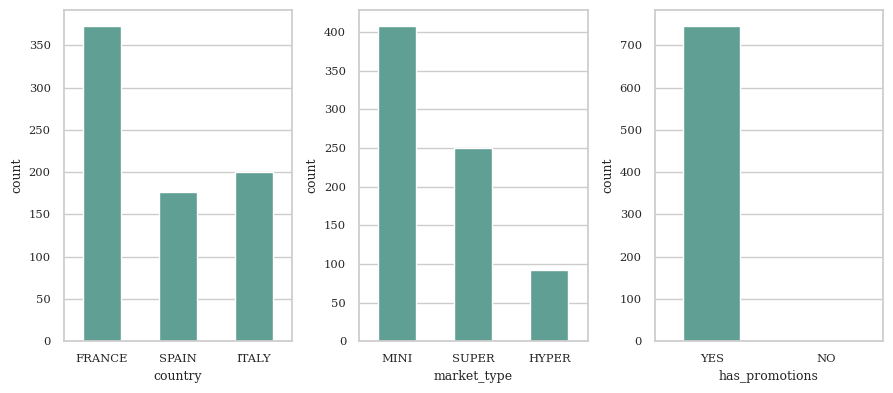

In [404]:
cat_names = ["country", "market_type", "has_promotions"]

# countplots
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9, 4))
index = 0
ax = ax.flatten()
for col_name in cat_names:
	sns.countplot(x = col_name, data = merged_df, ax = ax[index], width = 0.5)
	index += 1
plt.tight_layout()

We can make the following observations.
- As for the variable `country`, the most numerous class is $\texttt{FRANCE}$, while $\texttt{SPAIN}$ and $\texttt{ITALY}$ have a similar number of observations.
- The majority of the markets are $\texttt{MINI}$ markets, while the number of $\texttt{HYPER}$ markets is pretty low;
- Almost all the markets have the possibility of getting promotions.

Note that the last countplot suggests that the number of observations with `has_promotion` equal to $\texttt{NO}$ is close to $0$. The exact number is in fact very low. We report it below.

In [405]:
print("- number of rows for which has_promotions is NO =", len(merged_df[merged_df["has_promotions"] == "NO"]))

- number of rows for which has_promotions is NO = 4


Let us now look at the boxplots in order to see if there is any outlier. 
We display only the ones corresponding to *quantitative* variables as for this purpose boxplots are not appropriate for *categorical* variables.

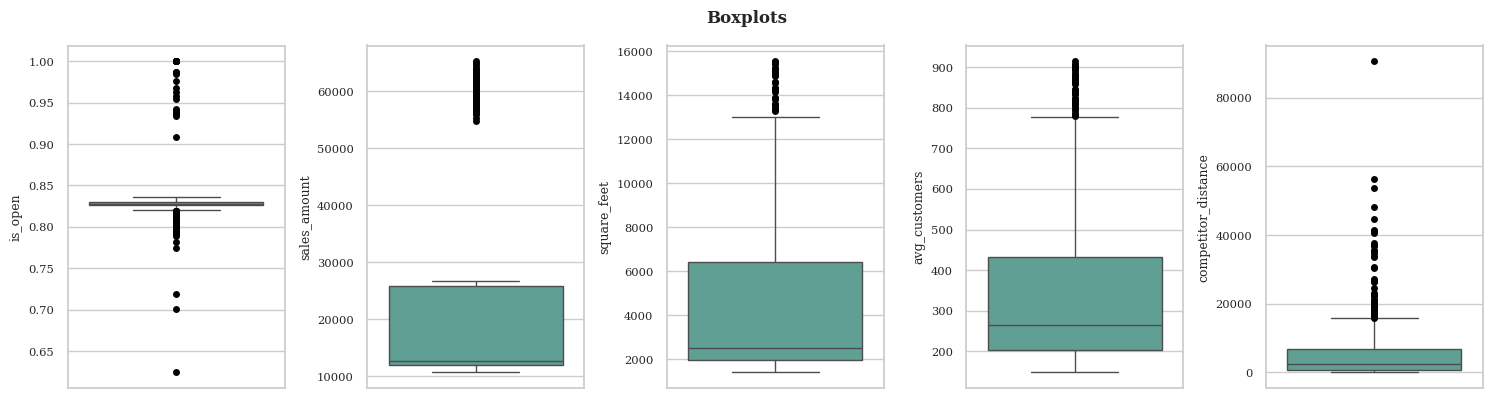

In [406]:
quant_names = ["is_open", "sales_amount", "square_feet", "avg_customers", "competitor_distance"]

# boxplots
fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
ax = ax.flatten()
index = 0
for col_name in quant_names:
	sns.boxplot(y = col_name, data = merged_df, ax = ax[index],
		flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
	index += 1
fig.suptitle("Boxplots", weight = "bold").set_fontsize("12")
plt.tight_layout()
plt.show()

As we can notice, in the variables `sales_amount`, `square_feet` and `avg_costumers` the ouliers seem to be the observations that reach the higher values, which of course correspond to the markets whose type is $\texttt{HYPER}$. This is probably due to the very small size of the class $\texttt{HYPER}$ if compared to the other two. <br>
As for the variables `is_open` and `competitor_distance`, they both seem to have a high percentage of outliers, which is a priori unexplainable. It might be useful to split the dataset with respect to the market type and see wether we can say something more. <br>
Before doing so, let us compute the percentage of outliers in each variable by exploiting the interquartile range ($\texttt{iqr}$). I.e., we compute the proportion of values which fall inside the following interval:
$$(-\infty, \texttt{quantile}(0.25) - 1.5 \cdot \texttt{iqr}] \cup [\texttt{quantile}(0.75) + 1.5 \cdot \texttt{iqr}, +\infty),$$
where $\texttt{iqr} = \texttt{quantile}(0.75) - \texttt{quantile}(0.25)$.

In [407]:
# percentage of outliers per column
merged_df_mt = merged_df.drop("market_type", axis = 1)
print("- percentage of outliers:")
for col_name, col in merged_df_mt[quant_names].items():
	q1 = col.quantile(0.25)
	q3 = col.quantile(0.75)
	iqr = q3 - q1
	outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
	print("\t - " + col_name + " = " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

- percentage of outliers:
	 - is_open = 9.33%
	 - sales_amount = 12.27%
	 - square_feet = 4.27%
	 - avg_customers = 5.07%
	 - competitor_distance = 8.8%


As expected, the percentage of outliers in quite high, especially for the variables `is_open`, `sales_amount` and `competitor_distance`.

Let us now divide the dataset by market type and then display again the boxplots together with the percentage of outliers computed by using the interquartile range.

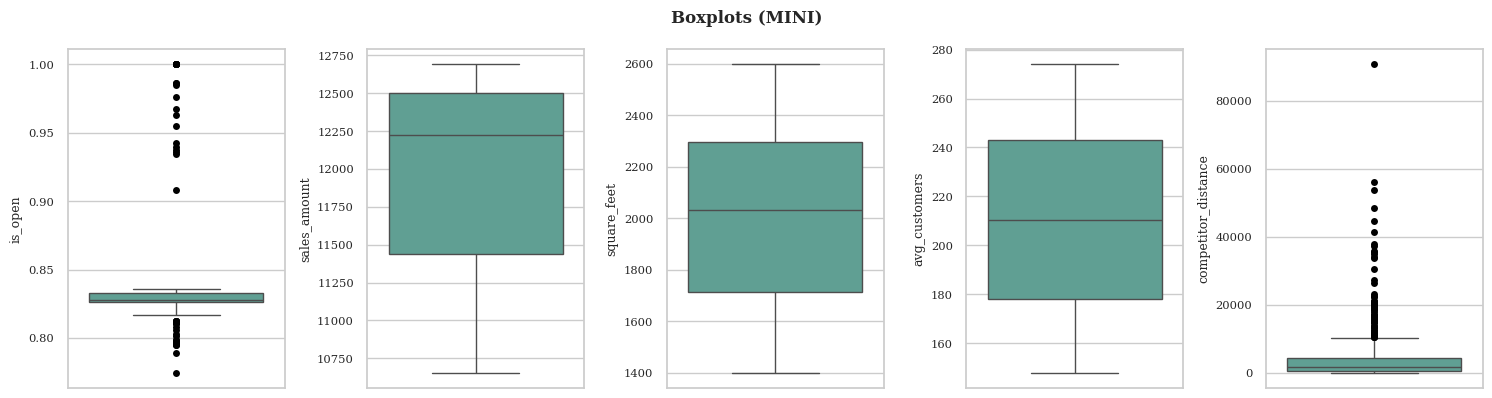

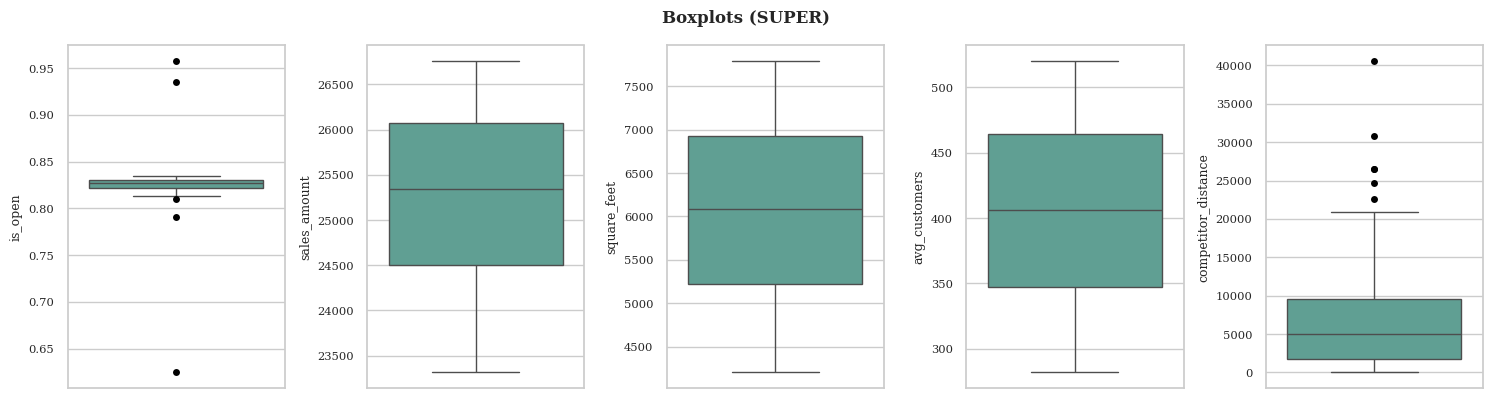

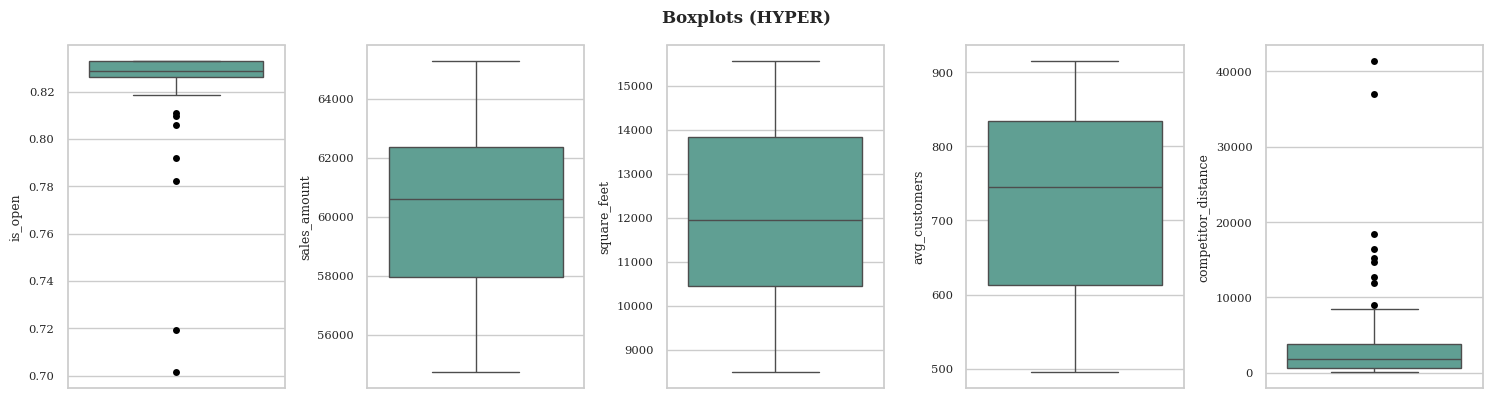

In [408]:
# boxplots (by market_type)
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type]
	fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
	ax = ax.flatten()
	index = 0
	for col_name in quant_names:
		sns.boxplot(y = col_name, data = merged_df_mt, ax = ax[index],
			flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
		index += 1
	fig.suptitle("Boxplots (" + market_type + ")", weight = "bold").set_fontsize("12")
	plt.tight_layout()
	plt.show()

In [409]:
# percentage of outliers per column (by market_type)
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type].drop("market_type", axis = 1)
	print("- " + market_type + ", percentage of outliers:")
	for col_name, col in merged_df_mt[quant_names].items():
		q1 = col.quantile(0.25)
		q3 = col.quantile(0.75)
		iqr = q3 - q1
		outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
		print("\t - " + col_name + " = " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

- MINI, percentage of outliers:
	 - is_open = 10.54%
	 - sales_amount = 0.0%
	 - square_feet = 0.0%
	 - avg_customers = 0.0%
	 - competitor_distance = 15.2%
- SUPER, percentage of outliers:
	 - is_open = 2.0%
	 - sales_amount = 0.0%
	 - square_feet = 0.0%
	 - avg_customers = 0.0%
	 - competitor_distance = 2.4%
- HYPER, percentage of outliers:
	 - is_open = 7.61%
	 - sales_amount = 0.0%
	 - square_feet = 0.0%
	 - avg_customers = 0.0%
	 - competitor_distance = 9.78%


The first thing to observe is that now the variables `sales_amount`, `square_feet` and `avg_costumers` have no outlier, which means that for each type of market the observations are homogeneous with respect to these variables. <br>
As for the variables `is_open` and `competitor_distance`, they have a high percentage of outliers for both $\texttt{MINI}$ and $\texttt{HYPER}$ markets, and a lower one for $\texttt{SUPER}$ markets.
This allows us to say that both these values do not depend on the type of market we are considering.

### Categorical variables encoding

We now encode the *categorical* variables: as for the variable `has_promotion` we just turn $\texttt{YES}$ to $1$ and $\texttt{NO}$ to $0$, while the variables `country` and `market_type` are both substituted by two dummy variables: `is_spain`, `is_italy` and `is_mini`, `is_super` respectively. In particular, `is_spain` is $1$ if the market is in $\texttt{SPAIN}$, $0$ otherwise; `is_mini` is $1$ if the market is $\texttt{MINI}$, $0$ otherwise, and so on. <br>
It is remarkable that we do not need additional dummy variables for the classes $\texttt{FRANCE}$ and $\texttt{HYPER}$ since this all the information is contained in the other dummy variables.

In [349]:
# split country and market_type in boolean variables:
# - we create a copy of both columns
# - we encode the two copies of country and market_type in dummy variable
merged_df = pd.concat([merged_df, merged_df["country"].rename("is_italy"),
	merged_df["market_type"].rename("is_super")], axis = 1)
merged_df.rename(columns = {"country": "is_spain", "market_type": "is_mini"}, inplace = True)
merged_df = merged_df[["sales_amount", "is_open", "is_spain", "is_italy", "is_mini", "is_super",
	"square_feet", "avg_customers", "competitor_distance", "has_promotions"]]
merged_df["is_spain"] = merged_df["is_spain"].map({"SPAIN": 1, "FRANCE": 0, "ITALY": 0})
merged_df["is_italy"] = merged_df["is_italy"].map({"SPAIN": 0, "FRANCE": 0, "ITALY": 1})
merged_df["is_mini"] = merged_df["is_mini"].map({"MINI": 1, "SUPER": 0, "HYPER": 0})
merged_df["is_super"] = merged_df["is_super"].map({"MINI": 0, "SUPER": 1, "HYPER": 0})

# encoding has_promotions: 1 = YES and 0 = NO
merged_df["has_promotions"] = merged_df["has_promotions"].map({"YES": 1, "NO": 0})

display(merged_df)

,sales_amount,is_open,is_spain,is_italy,is_mini,is_super,square_feet,avg_customers,competitor_distance,has_promotions
0,1.2610e+04,8.2740e-01,0,0,1,0,2437,248,58,1
1,2.6574e+04,8.2051e-01,0,0,0,1,6403,493,300,1
2,2.6124e+04,8.3014e-01,0,0,0,1,7544,340,1598,1
3,1.1856e+04,8.2051e-01,1,0,1,0,1940,165,2068,1
4,1.2393e+04,8.2466e-01,0,0,1,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...
745,1.2571e+04,8.3014e-01,0,0,1,0,1691,272,1843,1
746,1.2375e+04,8.2051e-01,0,0,1,0,1462,159,547,1
747,2.6405e+04,8.2740e-01,0,0,0,1,5946,488,2743,1
748,1.2542e+04,8.1868e-01,0,0,1,0,1413,239,1920,1


### Scatterplots & correlation matrix

Finally, let us display the scatterplots of each feature vs. `sales_amount` and the correlation matrix. We do so in order to see wether there is any predictor which potentially might affect more the target variable.

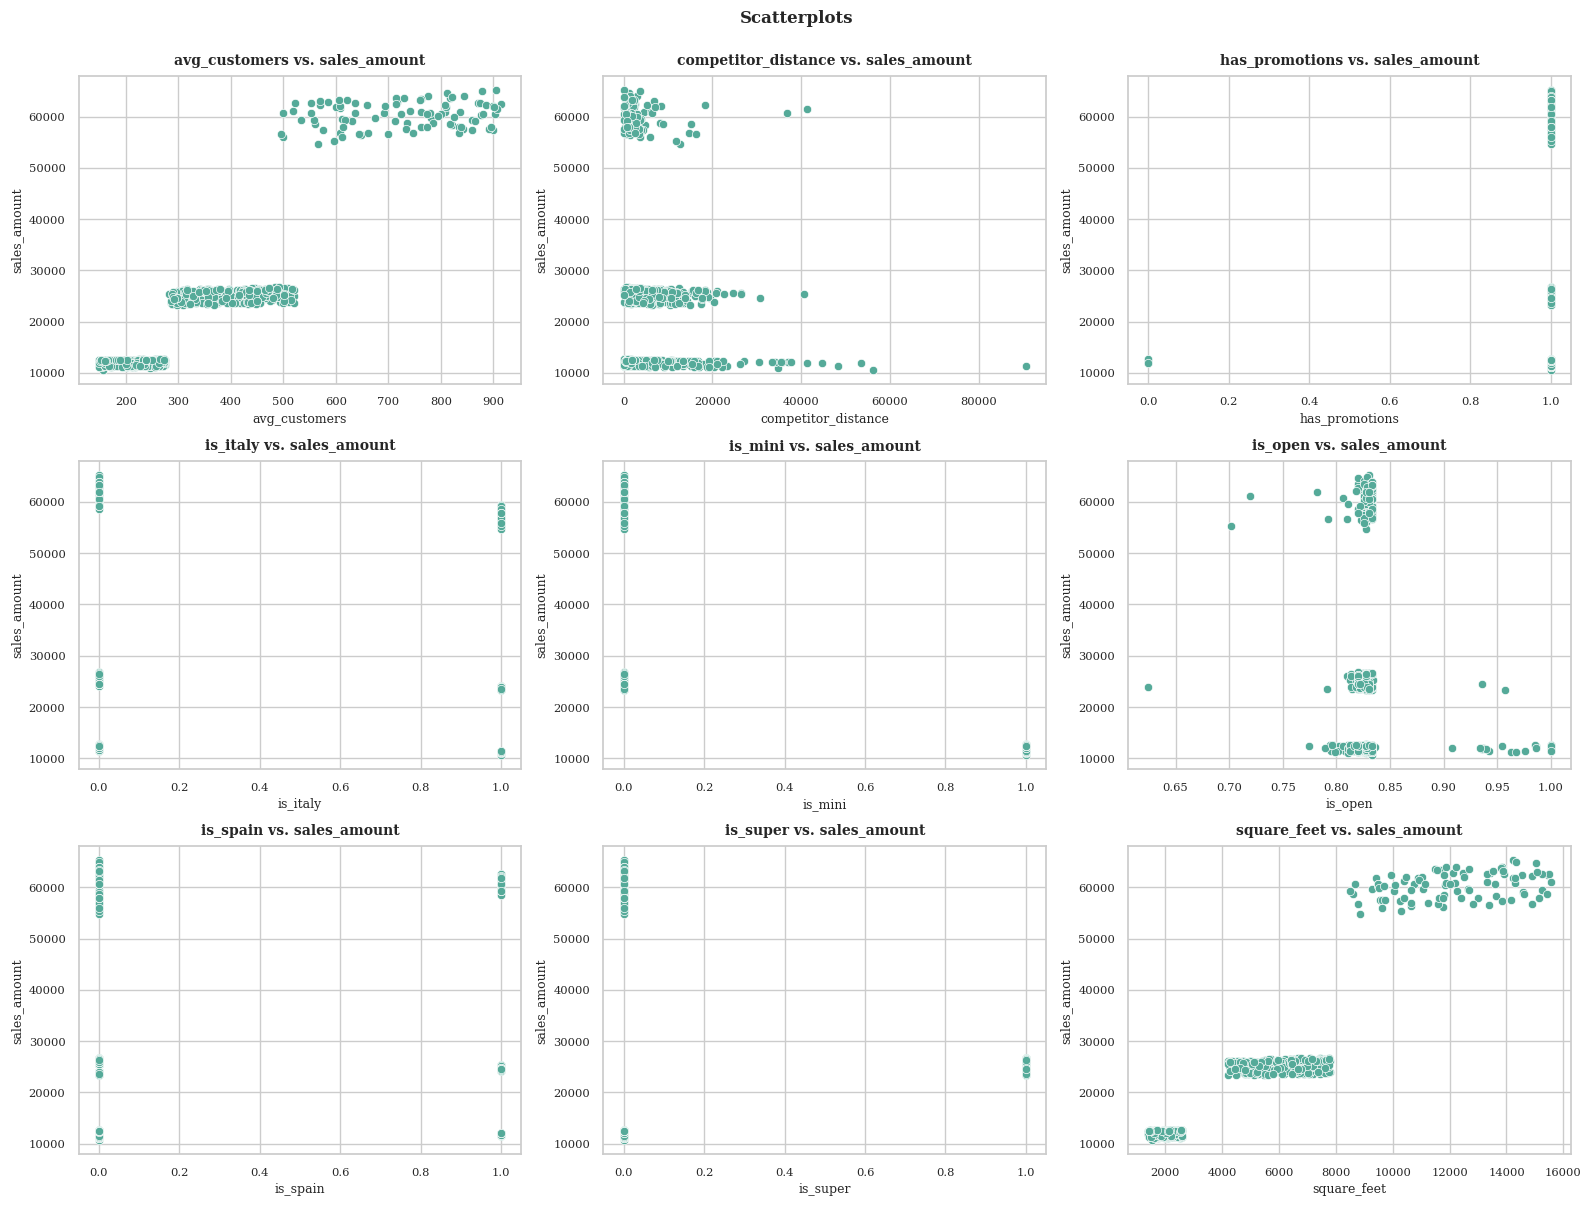

In [350]:
# scatterplots
fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (16, 12))
index = 0
ax = ax.flatten()
for col_name in merged_df.columns.difference(["sales_amount"]):
	current_plot = sns.scatterplot(y = merged_df["sales_amount"], x = merged_df[col_name], ax = ax[index])
	ax[index].set_title(col_name + " vs. sales_amount", weight = "bold", y = 1.01).set_fontsize("10")
	index = index + 1
fig.suptitle("Scatterplots", weight = "bold",  y = 1).set_fontsize("12")
plt.tight_layout()

As we might expect, the scatterplots `avg_costumers` vs. `sales_amount` and `sqaure_feet` vs. `sales_amount` (the first one and the last one respectively) contain three distinct clouds of points which correspond to $\texttt{MINI}$, $\texttt{SUPER}$ and $\texttt{HYPER}$ markets. 
There seem to be a direct proportionality between portions of `avg_costumers` and `square_feet` and the taget variable, however we cannot say the same if we consider each cloud separately, that is if we consider each market separately. We can still say that they can be helpful in explaining the target variable. <br>
Also the variables `is_mini` and `is_super` are related to the target: if a market is $\texttt{MINI}$ then it will have a low `sales_amount` value, if a market is $\texttt{SUPER}$ it will have a medium `sales_amount` value. <br>
The remaining scatterplots does not seem to show any explicit pattern.

Let us finally display the correlation matrix.

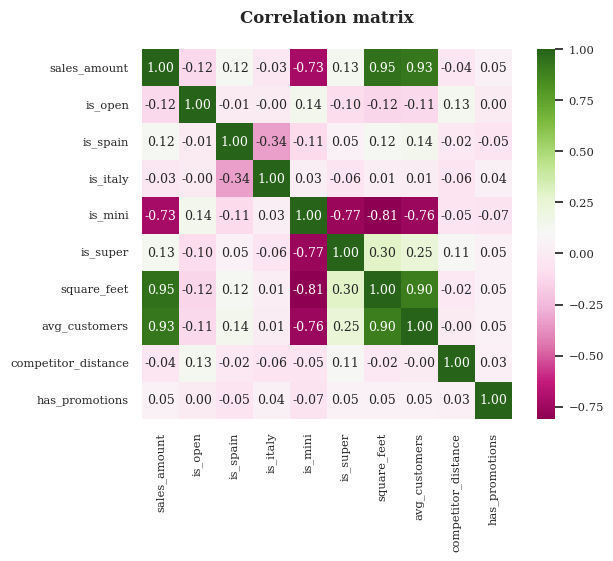

In [371]:
# correlation matrix
ax = sns.heatmap(merged_df.corr(), annot = True, cmap = "PiYG", fmt = ".2f", square = True)
ax.set_title("Correlation matrix", weight = "bold", y = 1.05).set_fontsize("12")
ax.tick_params(left = False, bottom = False)

The correlation between the target and the variables `square_feet` and `avg_costumers` (and also the correlation between them) is very high. Hence, we expect that both variables will play a major role in describing the target. <br>
Furthermore, we can observe that the variable `is_mini` is strongly correlated not only to `sales_amount` but also to `is_super`, `square_feet` and `avg_costumers`. So we expect also `is_mini` to be relevant in the target explaination.

# Objective 1

We consider here a linear relationship between target and predictors.

## Feature selection

Before fitting a linear model we perform feature selection in order to remove possible irrelevant variables. We report below the functions that carry out both forward and backward stepwise selection together with two other functions that compute and print the results of the selection procedure.

Notice that for computational reasons we decided not to use the best subset selection.

In [357]:
def calculate_metrics(y_test, y_pred, p):
	# description:
	# 	function to compute RSE, R2, and MSE of a linear model with p predictors.
	# input:
	# 	y_test 	= target observations
	# 	y_pred	= predicted values for the target observation
	# 	p		= number of predictors used to compute y_pred
	# output:
	# 	RSE		= relative standard error (RSE)
	# 	R2		= coefficient of determination (R^2)
	# 	MSE		= mean squared error (MSE)

	residuals = y_test - y_pred
	RSE = (sum(residuals ** 2) / (len(residuals) - p - 1)) ** 0.5
	R2 = 1 - sum(residuals ** 2) / sum((y_test - y_test.mean()) ** 2)
	MSE = (residuals ** 2).mean()
	return RSE, R2, MSE

def better_by_criteria(value_1, value_2, criteria):
	# description:
	#  	function to check wheather the first given error (value_1) is better than the second one (value_2) according to a fixed criteria.
	#  	if the criteria is MSE or RSE value_1 is better than value_2 when value_1 < value_2.
	#  	if the criteria is R2 value_1 is better than value_2 when value_1 > value_2.		
	# input:
	# 	value_1		= first of the two errors, we want to check whether is better than value_2
	# 	value_2		= second of the two errors
	# 	criteria	= RSE, R2 or MSE
	# output:
	# 	bool		= True if value_1 is better than value_2 by criteria, False otherwise

	if (criteria == "RSE") or (criteria == "MSE"):
		return (value_1 < value_2)
	elif (criteria == "R2"):
		return (value_1 > value_2)

def forward_selection_v2(training_method, X, y, criteria, alpha = 0.1):
	# description:
	# 	implementation of the algorithm forward_selection_v2.
	# 	in order to select the best model it is used a 5-fold cross validation.
	# input:
	#	training_method = method used to perform the linear regression (OLS, Ridge or Lasso)
	#	X				= predictors
	#	y				= target
	#	criteria		= criteria to decite which of the feature set is better (RSE, R2 or MSE)
	#	(alpha			= optional parameter used by Ridge and Lasso, set to 0.1 by default)
	# output:
	#	best_features 	= features selected by the best model selected (for each k)
	#	best_metrics 	= metrics obtained by applying the cross-validation to the best model selected (for each k)

	# k-fold
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# initialize parameters
	# - p = number of total features
	# - best_features = list containing the features selected by the best model selected for each k 
	# - best_metrics = list containing the metrics (errors) obtained applying the 5-fold cv to the best model selected for each k 
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())

	# list of the features inserted in the current model	
	current_features = []
	# list of the selectable features
	remaining_features = list(X.columns)
	
	# k = number of features
	for k in range(0, p):
		# new_feature = new feature to insert in the current model
		for new_feature in remaining_features:
			# model_features = features in the current model
			model_features = current_features + [new_feature]
			# X_subset = observations of the features in the current model
			# (add a constant for the intercept term)
			X_subset = X[model_features]
			X_subset = sm.add_constant(X_subset)  
			
			# cv_folds = empty array to store mse for each fold
			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0,
				"len": 0
			}

			# for each fold fit the model estimate cv test error using the mean of the considered statistics in all folds
			for train_index, validation_index in kf.split(X_subset):
				# split X_subset in train and validation
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				
				# fit:
				# it is possible to select several training methods to perform the linear regression, depending from
				# the selected training_method we perform OLS, Ridge(alpha = alpha) or Lasso(alpha = alpha)
				if training_method == "OLS":
					model = sm.OLS(y_train, X_train).fit()
				elif training_method == "Ridge":
					model = Ridge(alpha = alpha).fit(X_train, y_train)
				elif training_method == "Lasso":
					model = Lasso(alpha = alpha).fit(X_train, y_train)
				else:
					print("error: " + training_method + " is not an available model")
					return

				# predict
				y_pred = model.predict(X_validation)
				
				# computate and store the regression errors: RSE, R2 and MSE
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k + 1)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE
				cv_folds["len"] = cv_folds["len"] + 1
			
			# compute the 5-fold errors
			cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
			
			# if the estimation of the error is better (according to the selected criteria) we store metrics and features
			if better_by_criteria(cv_folds[criteria], best_metrics[k][criteria], criteria):
				best_metrics[k]["RSE"] = cv_folds["RSE"]
				best_metrics[k]["R2"] = cv_folds["R2"]
				best_metrics[k]["MSE"] = cv_folds["MSE"]
				best_features[k] = model_features
		
		# update current/remaining_features
		current_features = best_features[k]
		remaining_features = list(set(remaining_features) - set(current_features))

	return best_features, best_metrics

def backward_selection_v2(training_method, X, y, criteria, alpha = 0.1):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# initialize parameters
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())
	current_features = list(X.columns)
	removable_features = [" "]
	
	# for each number of features
	for k in range(p, 0, -1):
		for new_feature in removable_features:
			model_features = list(set(current_features) - set([new_feature]))
			X_subset = X[model_features]
			# add a constant for the intercept term
			X_subset = sm.add_constant(X_subset)  
			# initialize empty array to store mse for each fold
			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0,
				"len": 0
			}
			# for each fold fit the model and estimate cv test error (using the mean of MSE in all folds)
			for train_index, validation_index in kf.split(X_subset):
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				if training_method == "OLS":
					model = sm.OLS(y_train, X_train).fit()
				elif training_method == "Ridge":
					model = Ridge(alpha = alpha).fit(X_train, y_train)
				elif training_method == "Lasso":
					model = Lasso(alpha = alpha).fit(X_train, y_train)
				else:
					print("error: " + training_method + " is not an available model")
					return
				y_pred = model.predict(X_validation)
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE
				cv_folds["len"] = cv_folds["len"] + 1
			cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
			# if the estimation of the test error is reduced, save metrics and model
			if better_by_criteria(cv_folds[criteria], best_metrics[k - 1][criteria], criteria):
				best_metrics[k - 1]["RSE"] = cv_folds["RSE"]
				best_metrics[k - 1]["R2"] = cv_folds["R2"]
				best_metrics[k - 1]["MSE"] = cv_folds["MSE"]
				best_features[k - 1] = model_features
		current_features = best_features[k - 1]
		removable_features = current_features
	return best_features, best_metrics

def report_best_parameters(features, metrics, criteria, model_name = "", verbose = True):
	# description:
	# 	function to find and report (if in verbose mode) the best metrics in a list of metrics and their corresponding features.
	# input:
	# 	features 		= list of features associated to the metrics
	# 	metrics 		= list of dictionaries containing the 3 metrics
	#	criteria		= criteria to decite which of the metrics set is better (RSE, R2 or MSE)
	#	(model_name		= name of the model used to generate the metrics and the features
	#	verbose			= dummy variable, if True an extensive report is printed)
	
	p = len(metrics)
	criteria_list = [metrics[k][criteria] for k in range(p)]
	if (criteria == "RSE") or (criteria == "MSE"):
		criteria_best_k = criteria_list.index(min(criteria_list))
	elif (criteria == "R2"):
		criteria_best_k = criteria_list.index(max(criteria_list))
	
	if verbose == True:
		if model_name != "":
			print(model_name + ", ", end = "")
		print("best parameters:\n\t- k =", criteria_best_k + 1, "\n\t- features =", features[criteria_best_k])
		print("\t- metrics:\n\t\t- RSE =", metrics[criteria_best_k]["RSE"], "\n\t\t- R2 =",
			metrics[criteria_best_k]["R2"], "\n\t\t- MSE =", metrics[criteria_best_k]["MSE"])
	
	return features[criteria_best_k], metrics[criteria_best_k]

def plot_metrics(metrics, name_variables = "features"):
	# description:
	# 	function to plot lists of metrics (RSE, R2 and MSE).
	# input:
	# 	metrics 		= list of dictionaries containing the 3 metrics
	#	(name_variables	= name of the variables associated to the indexes of the list)

	p = len(metrics)
	_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
	index = 0
	ax = ax.flatten()
	for error_type in ["RSE", "R2", "MSE"]:
		error_list = [metrics[k][error_type] for k in range(p)]
		sns.lineplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		sns.scatterplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		ax[index].set_title(error_type)
		ax[index].set_xlabel("k (n. " + name_variables + ")")
		ax[index].set_ylabel(error_type + "(k)")
		index = index + 1
	plt.tight_layout()
	plt.show()

We perform here the forward feature selection for the multiple linear regression model with OLS as fitting procedure. Moreover, among MSE, RSE and R2, we use the RSE metric to pick the best model, since it allows us the reduce more the number of predictors and at the same time to obtain an accuracy which is almost identical to the other two cases.

OLS best linear, best parameters:
	- k = 7 
	- features = ['square_feet', 'avg_customers', 'is_super', 'is_mini', 'is_italy', 'is_spain', 'competitor_distance']
	- metrics:
		- RSE = 658.1887588370063 
		- R2 = 0.9982573016464691 
		- MSE = 413572.984906783


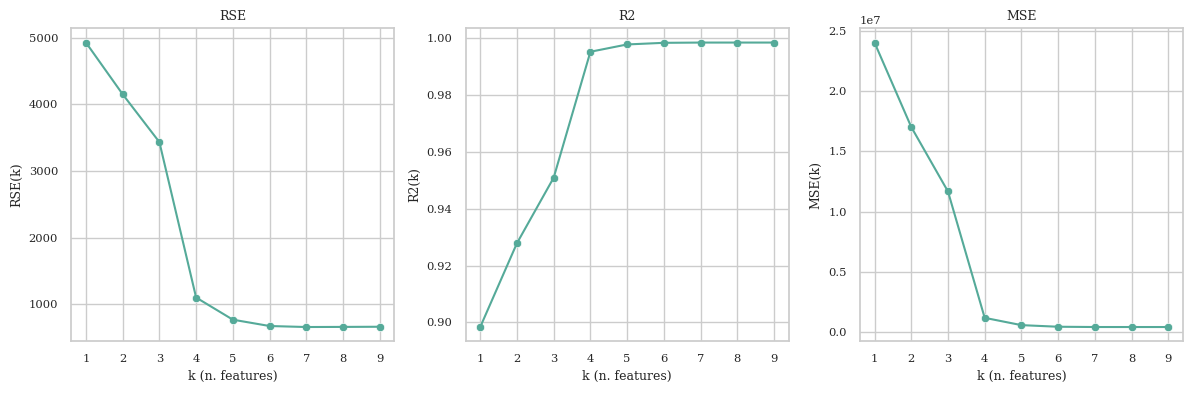

In [358]:
# model
model_name = "OLS best linear"

# load the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

# calculate and display the results
criteria = "RSE"
training_method = "OLS"
all_best_features, all_best_metrics = forward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, model_name)
ols_best_linear_metrics = best_metrics
plot_metrics(all_best_metrics)

# store cv errors
cv_errors = pd.DataFrame([best_metrics])
cv_errors = cv_errors.rename(index = {0: model_name})

The forward feature selection eliminates the variables `is_open` and `has_promotions`. It seems reasonable since, as we saw, `has_promotions` is $\texttt{YES}$ always but four times, while `is_open` is almost uncorrelated to both the target variable and the other predictors. 

The above plot shows the error metrics of the best model of each iteration of the selection procedure. We can observe that in each plot the stability is reached with $6\,/\,7$ features, hence adding more features does not give any relevant benefit. 

Finally, notice that with $7$ features we obtain an R2 value which is almost $1$. So the model seem to be able to explain very well the variability in the target variable.

## Best linear model analysis

We now analyze the best multiple linear regression model found above. 

After splitting the dataset in train and test sets, we fit the model and then compute the model accuracy.

In [45]:
# split in train and test
X = merged_df[best_features]
y = merged_df["sales_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)

# fit the linear regression model
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_with_intercept).fit()

# model accuracy (RSE, R2 and MSE)
y_pred = model.predict(X_test_with_intercept)
RSE, R2, MSE = calculate_metrics(y_test, y_pred, p = X_train.shape[1])
print("test errors:\n\t- RSE:", RSE, "\n\t- R2:", R2, "\n\t- MSE:", MSE)

test errors:
	- RSE: 575.5061159721496 
	- R2: 0.9985299718418624 
	- MSE: 313542.9007468774


Then, we display the coefficients' estimates together with the corresponding standard errors (SE), t-statistics, p-values and $95\%$ confidence intervals.

In [46]:
# coefficient estimates 
coefficients = model.params

# dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
	row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
	rows.append(row)
summary_coeff = pd.DataFrame(rows, columns = ["", "ols estimation", "SE", "t-stats", "p-value"])
summary_coeff

,,ols estimation,SE,t-stats,p-value
0,const,55742.442570,436.364747,127.742773,0.000000e+00
1,square_feet,0.273939,0.026446,10.358259,3.211469e-23
2,avg_customers,2.944094,0.396751,7.420511,4.073315e-13
3,is_super,-32524.127510,224.107492,-145.127355,0.000000e+00
4,is_mini,-44017.672907,346.367329,-127.083790,0.000000e+00
5,is_italy,-2065.714140,63.466797,-32.547950,5.456902e-134
6,is_spain,-897.419660,67.839991,-13.228476,3.492094e-35
7,competitor_distance,-0.020311,0.003100,-6.552110,1.234140e-10


In [47]:
# 95% confidence intervals
confidence_intervals = model.conf_int(alpha = 0.05)  # 0.05 for a 95% confidence interval

print("the 95% confidence intervals:")
for index, value in coefficients.items():
    current_conf_int = confidence_intervals.loc[index].values
    print("\t - ",index, "is", current_conf_int)

the 95% confidence intervals:
	 -  const is [54885.43125518 56599.45388459]
	 -  square_feet is [0.22199882 0.32587933]
	 -  avg_customers is [2.16488354 3.72330443]
	 -  is_super is [-32964.26997689 -32083.98504269]
	 -  is_mini is [-44697.93115869 -43337.41465574]
	 -  is_italy is [-2190.36161382 -1941.0666666 ]
	 -  is_spain is [-1030.65599507  -764.18332421]
	 -  competitor_distance is [-0.026399   -0.01422274]


All the p-values are a lot lower than $0.05$ (three of them are even $0$). Hence, all the selected predictors and the intercept are needed. 

### Residuals analysis

We now move to the residuals analysis. In particular, we first check if the error terms are uncorrelated, second if their variance is constant, that is we control wether in the model there is heteroscedasticity.

In order to check the correlation of error terms we first plot the residuals, then we quantify the correlation by computing both the autocorrelation with the lagged(1) residuals and the Durbin-Watson statistic.

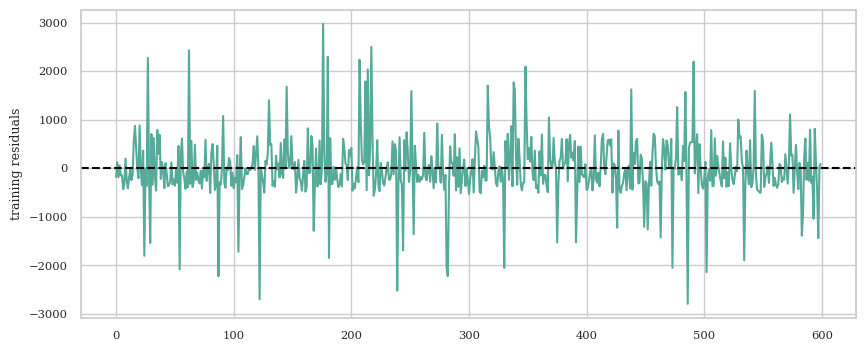

In [48]:
residuals_training = model.resid

plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.ylabel("training residuals")
plt.show()

In [49]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation:", round(autocorrelation, 5), "\n- durbin-watson statistic:", round(durbin_watson, 5))

- autocorrelation: 0.00078 
- durbin-watson statistic: 1.94394


Both the plot and the above values suggest there is no correlation of error terms. Indeed:
- in the plot there is no discernible pattern;
- the autocorrelation value is very close to $0 ;
- the Durbin-Watson statistic is near $2$.

<br>
In order to check heteroscedasticity, we first plot the training fitted values vs. the training residuals, then we perform the Breush-Pagan Lagrange multiplier test.

In [50]:
mini_index = merged_df[merged_df["is_mini"] == 1].index
super_index = merged_df[merged_df["is_super"] == 1].index
hyper_index = merged_df[(merged_df["is_mini"] == 0) & (merged_df["is_super"] == 0)].index
list_index = [mini_index, super_index, hyper_index]
list_names = ["Mini", "Super", "Hyper"]

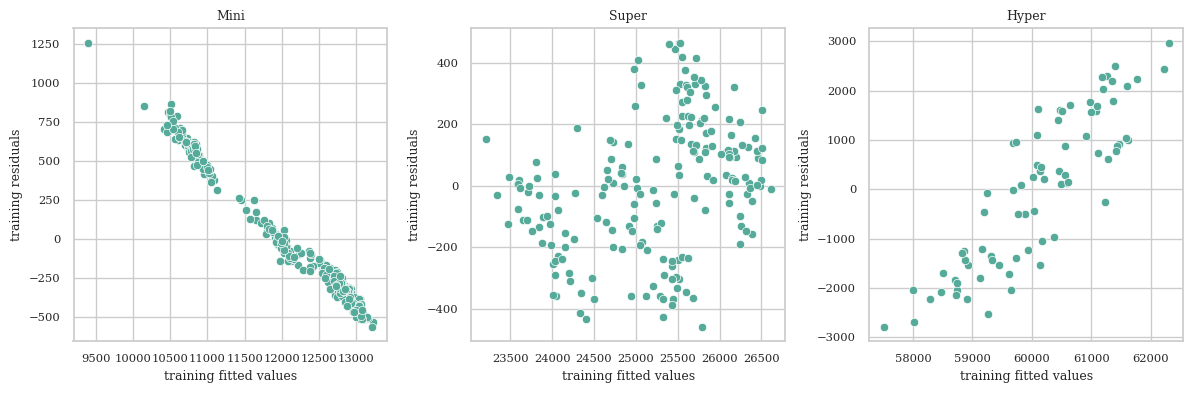

In [51]:
# variance of error terms: residuals vs fitted values
_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
index = 0
ax = ax.flatten()
for index in range(3):
	remove_indexes = list_index[:index] + list_index[(index + 1):]
	X_train_with_intercept_market = X_train_with_intercept.loc[X_train_with_intercept.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	residuals_training_market = residuals_training.loc[residuals_training.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	sns.scatterplot(x = model.predict(X_train_with_intercept_market), y = residuals_training_market, ax = ax[index])
	ax[index].set_title(list_names[index])
	ax[index].set_xlabel("training fitted values")
	ax[index].set_ylabel("training residuals")
	index = index + 1
plt.tight_layout()

In [52]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic:", lzip(name, test)[0][1], "\n- p-value:", lzip(name, test)[1][1])

- lagrange multiplier statistic: 335.148415502503 
- p-value: 1.8572765906962078e-68


It is already evident from the plot that the variance of errors terms is not constant. This is confirmed by the Breush-Pagan Lagrange multiplier test: the p-value is very close to $0$, hence the null hypothesis of homoscedasticity is rejected. A standard approach for solving this problem is to transform the target by using the logaritm. We will explore this approach in the section dedicated to the Objective 2 and not here, since when we pass to the logaritm the relationship between the target and the predictors is not linear anymore.

### Collinearity

The last thing we need to check is collinearity. We compute it by using the variance inflation factor (VIF).

In [53]:
# collinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif

,VIF Factor,Feature
0,16.135825,square_feet
1,19.946057,avg_customers
2,1.889666,is_super
3,2.085008,is_mini
4,1.572465,is_italy
5,1.543671,is_spain
6,1.451100,competitor_distance


The VIF factor is overall quite low, except for the variables `square_feet` and `avg_costumers`. We could have expected it since we saw that these two variables are highly correlated. Despite the high VIF factor we decide not to remove any of them as they are among the first ones to be selected in both forward and backward selection, which means that they are both important in explaining/predicting the target.

### Backward selection

Here we run the backward feature selection for the multiple linear regression model with OLS as fitting procedure. We only do this to check whether the model selected as best is the same as the model selected by the farward procedure. Moreover, for consistency with what was done before, among MSE, RSE and R2, we use the RSE metric to pick the best model.

OLS best linear (backward):
	- k = 7 
	- features = ['square_feet', 'is_spain', 'competitor_distance', 'is_italy', 'avg_customers', 'is_mini', 'is_super']
OLS best linear (backward) metrics:
	- RSE: 658.1887588370544
	- R2: 0.9982573016464686
	- MSE: 413572.984906854


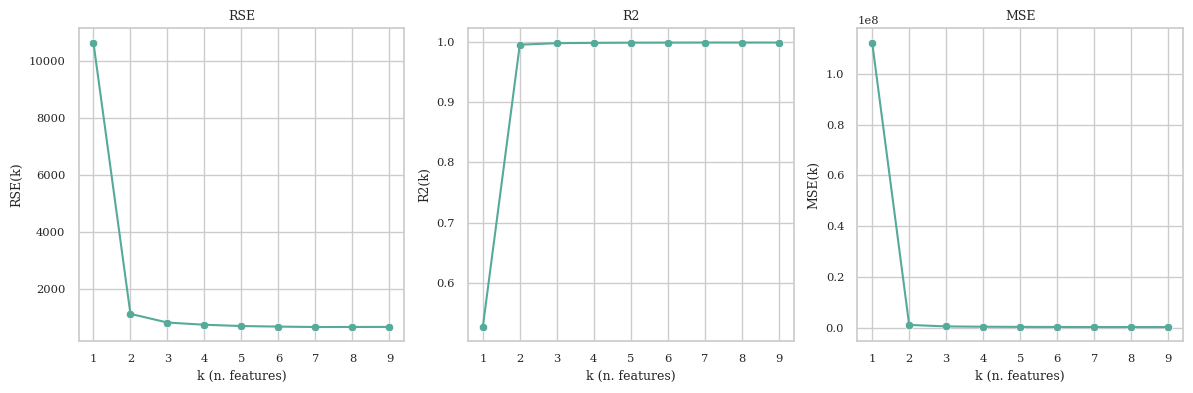

In [55]:
model_name = "OLS best linear (backward)"

X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

criteria = "RSE"
training_method = "OLS"
all_best_features, all_best_metrics = backward_selection_v2(training_method, X, y, criteria)
best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, model_name)
plot_metrics(all_best_metrics)

As we can see, the linear model selected as best is the same as the one selected by the forward procedure. The only relevant thing here is that the error metrics decrease/increase more rapidly than in forward selection, however this does not affect the final result.

## Shrinkage methods

In this section we perform the forward feature selection for the multiple linear regression model estimating the coefficients with Ridge regression and Lasso. The aim here is to check wether we can reach a better accuracy by applying shrinkage techniques.

Before running feature selection we standardize the dataset.

In [56]:
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
y = merged_df["sales_amount"]

criteria = "RSE"
alpha_values = [0.001, 0.01, 0.1, 1]

### Ridge

In [57]:
model_name = "Ridge best linear"
training_method = "Ridge"
print(training_method + ":")
best_alpha = 0
best_alpha_metrics = {
	"RSE": float("inf"),
	"R2": 0,
	"MSE": float("inf"),
	"features": [],
	"k": 0,
}
for alpha in alpha_values:
	all_best_features, all_best_metrics = forward_selection_v2(training_method, X_scaled, y, criteria, alpha = alpha)
	best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, verbose = False)
	if best_metrics["RSE"] < best_alpha_metrics["RSE"]:
		best_alpha_metrics["RSE"] = best_metrics["RSE"]
		best_alpha_metrics["R2"] = best_metrics["R2"]
		best_alpha_metrics["MSE"] = best_metrics["MSE"]
		best_alpha_metrics["features"] = best_features
		best_alpha_metrics["k"] = len(best_features)
		best_alpha = alpha
print("\t" + model_name + ":\n\t\t- alpha =", best_alpha,"\n\t\t- k =", best_alpha_metrics["k"], "\n\t\t- features =", best_alpha_metrics["features"])
print("\t" + model_name, "metrics:\n\t\t- RSE:", best_alpha_metrics["RSE"])
print("\t\t- R2:", best_alpha_metrics["R2"])
print("\t\t- MSE:", best_alpha_metrics["MSE"])

cv_errors = pd.concat([cv_errors, pd.DataFrame([{key: value for key, value in best_alpha_metrics.items() if key not in ["k", "features"]}])])
cv_errors = cv_errors.rename(index = {0: model_name})

Ridge:
	Ridge best linear:
		- alpha = 0.001 
		- k = 7 
		- features = ['square_feet', 'avg_customers', 'is_super', 'is_mini', 'is_italy', 'is_spain', 'competitor_distance']
	Ridge best linear metrics:
		- RSE: 658.1989252297045
		- R2: 0.9982572692829595
		- MSE: 413580.41877036606


With Ridge regression we obtain the same best features and almost the same error values. In particular, the RSE is larger by $0.01$ than the value obtained with OLS. Hence, we can conclude that using Ridge regression does not improve the model's accuracy.

### Lasso

In [58]:
model_name = "Lasso best linear"
training_method = "Lasso"
print(training_method + ":")
best_alpha = 0
best_alpha_metrics = {
	"RSE": float("inf"),
	"R2": 0,
	"MSE": float("inf"),
	"features": [],
	"k": 0,
}
for alpha in alpha_values:
	all_best_features, all_best_metrics = forward_selection_v2(training_method, X_scaled, y, criteria, alpha = alpha)
	best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, verbose = False)
	if best_metrics["RSE"] < best_alpha_metrics["RSE"]:
		best_alpha_metrics["RSE"] = best_metrics["RSE"]
		best_alpha_metrics["R2"] = best_metrics["R2"]
		best_alpha_metrics["MSE"] = best_metrics["MSE"]
		best_alpha_metrics["features"] = best_features
		best_alpha_metrics["k"] = len(best_features)
		best_alpha = alpha
print("\t" + model_name + ":\n\t\t- alpha =", best_alpha,"\n\t\t- k =", best_alpha_metrics["k"], "\n\t\t- features =", best_alpha_metrics["features"])
print("\t" + model_name, "metrics:\n\t\t- RSE:", best_alpha_metrics["RSE"])
print("\t\t- R2:", best_alpha_metrics["R2"])
print("\t\t- MSE:", best_alpha_metrics["MSE"])

cv_errors = pd.concat([cv_errors, pd.DataFrame([{key: value for key, value in best_alpha_metrics.items() if key not in ["k", "features"]}])])
cv_errors = cv_errors.rename(index = {0: model_name})

Lasso:
	Lasso best linear:
		- alpha = 0.001 
		- k = 7 
		- features = ['square_feet', 'avg_customers', 'is_super', 'is_mini', 'is_italy', 'is_spain', 'competitor_distance']
	Lasso best linear metrics:
		- RSE: 658.189060588481
		- R2: 0.9982573006985387
		- MSE: 413573.20957574714


Similarly to what happens with Ridge regression, also with Lasso we obtain the same best features and similar error values. In particular, here the RSE is larger by $0.0003$ than the RSE obtained with OLS.

In conclusion, we can say that shrinkage techniques are not useful. 

## Dimensionality reduction techniques

### PCA

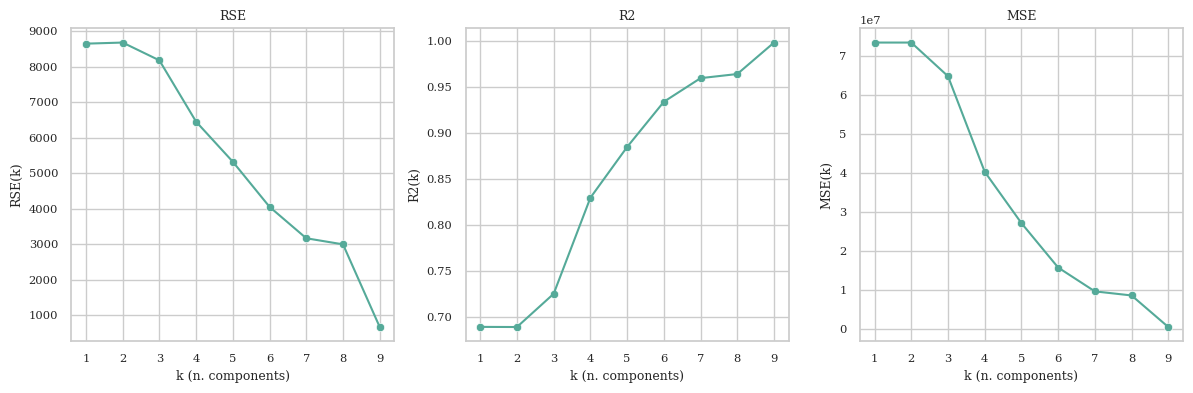

In [59]:
# PCA
def pca_regression(X, y):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

	# standardize features by removing the mean and scaling to unit variance
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pca_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pca = []
	for _ in range(p):
		errors_pca.append(errors_pca_k.copy())

	# for each number of principal components
	for k in range(1, p + 1):
		# transform using n_components for PCA
		pca = PCA(n_components = k)
		X_pca = pca.fit_transform(X_scaled)
		X_pca = pd.DataFrame(X_pca)
		# add a constant for the intercept term
		X_pca = sm.add_constant(X_pca)  
		# initialize empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		# for each fold fit the model
		for train_index, validation_index in kf.split(X_pca):
			X_train, X_validation = X_pca.iloc[train_index], X_pca.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			model = sm.OLS(y_train, X_train).fit()
			y_pred = model.predict(X_validation)
			RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_train.shape[1])
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		# save errors
		errors_pca[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pca[k - 1]["R2"] = cv_folds["R2"]
		errors_pca[k - 1]["MSE"] = cv_folds["MSE"]
	return errors_pca

X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

errors_pca = pca_regression(X, y)
plot_metrics(errors_pca, "components")

non è utile fare pca (si vede dai plot). <br>
in realtà ce lo aspettavamo perchè la pca non è un metodo indicato nel caso in cui si abbiamo sia variabili categoriale che variabili quantitative. <br>
l'effetto della standardizzazione dipende dalla numerosità delle categorie e non è perfettamente chiaro quale sia la loro influenza.

note: avendo standardizzato i predittori in teoria non sarebbe possibile arrivare a trovare i delta changes (risalire ai coefficienti della regressione rispetto ai predittori originali). comunque noi non lo dobbiamo fare

### PLS

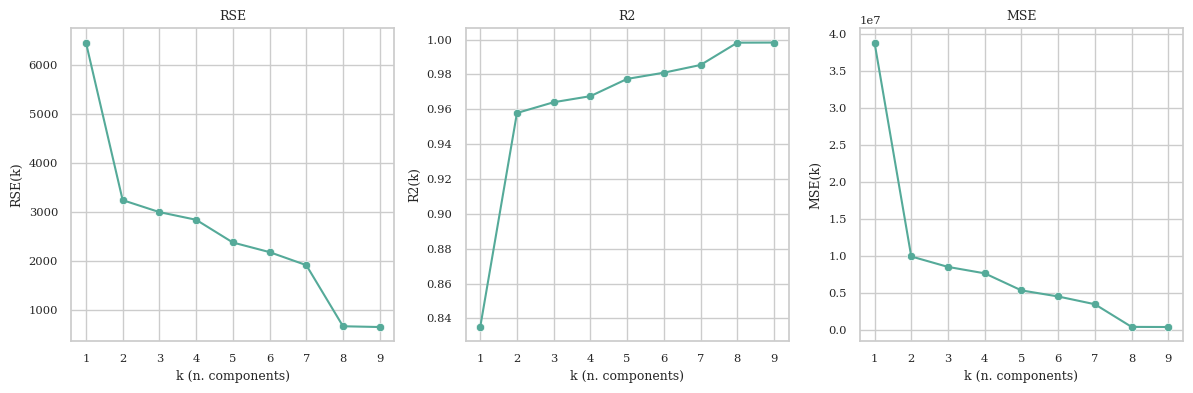

In [60]:
# PLS
def pls_regression(X, y):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

	# standardize features by removing the mean and scaling to unit variance
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pls_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pls = []
	for _ in range(p):
		errors_pls.append(errors_pls_k.copy())

	# for each number of principal components
	for k in range(1, p + 1):
		# transform using n_components for PLS
		pls = PLSRegression(n_components = k) 
		# initialize empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		# for each fold fit the model
		for train_index, validation_index in kf.split(X_scaled):
			X_train, X_validation = X_scaled.iloc[train_index], X_scaled.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			pls.fit(X_train, y_train)
			y_pred = pls.predict(X_validation)
			y_pred = pd.Series(y_pred)
			RSE, R2, MSE = calculate_metrics(y_validation.reset_index(drop = True), y_pred, X_train.shape[1]) 
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		# save errors
		errors_pls[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pls[k - 1]["R2"] = cv_folds["R2"]
		errors_pls[k - 1]["MSE"] = cv_folds["MSE"]
	return errors_pls

errors_pls = pls_regression(X, y)
plot_metrics(errors_pls, "components")

non è utile fare pls (si vede dai plot)

## Conclusions

non è significativa la differenza, scegliamo quindi ols che è un modello più semplice

In [61]:
pd.set_option('display.float_format', lambda x: '%.4e' % x)
display(cv_errors)

,RSE,R2,MSE
OLS best linear,6.5819e+02,9.9826e-01,4.1357e+05
Ridge best linear,6.5820e+02,9.9826e-01,4.1358e+05
Lasso best linear,6.5819e+02,9.9826e-01,4.1357e+05


In [62]:
# split in train and test
X = merged_df[best_features]
y = merged_df["sales_amount"]

# fit the linear regression model
X_with_intercept = sm.add_constant(X)
model = sm.OLS(y, X_with_intercept).fit()

# coefficient estimates 
coefficients = pd.DataFrame(model.params)
coefficients.rename(columns = {0: "coefficients"})

,coefficients
const,5.5695e+04
square_feet,2.7822e-01
avg_customers,3.1309e+00
is_super,-3.2576e+04
is_mini,-4.4017e+04
is_italy,-2.0448e+03
is_spain,-9.4054e+02
competitor_distance,-1.9097e-02


# Objective 2

In [63]:
cv_mse = pd.DataFrame([{"MSE": cv_errors["MSE"]["OLS best linear"]}])
cv_mse = cv_mse.rename(index = {0: "linear regression"})
cv_mse

,MSE
linear regression,4.1357e+05


## Log linear regression

solution to heteroskedasticity: log of the target

### Feature selection

In [64]:
# X_scaled
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

# y
y = merged_df["sales_amount"]

log linear regression:
	- k = 7 
	- features = ['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers']
log linear regression metrics:
	- RSE: 0.002448605234753504
	- R2: 0.9999812177631838
	- MSE: 5.706365629993585e-06


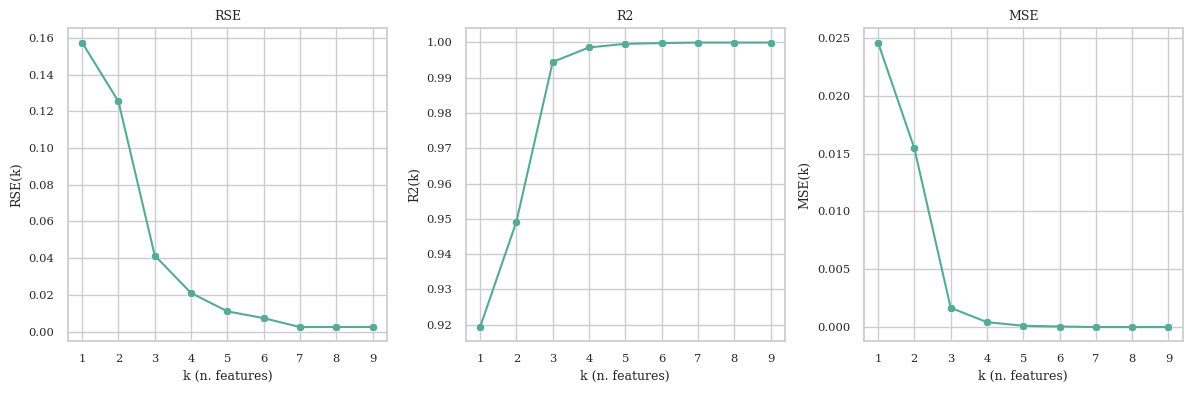

In [65]:
model_name = "log linear regression"

criteria = "RSE"
training_method = "OLS"
all_best_features, all_best_metrics = forward_selection_v2(training_method, X, np.log(y), criteria)
best_features, best_metrics = report_best_parameters(all_best_features, all_best_metrics, criteria, model_name)
plot_metrics(all_best_metrics)

osservazione: abbiamo scelto di usare l'RSE per selezionare le features ma in realtà usando l'MSE o l'R2 il risultato è invariato.

### Cross-validation

$$y = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n + \varepsilon = \hat{y} + \varepsilon \, \implies \, \textit{residuals} = \varepsilon = y - \hat{y}$$
$$\log(y) = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n = \widehat{\log(y)} + \varepsilon \, \implies \, \varepsilon = \log(y) - \widehat{\log(y)}, \text{ hence we consider } \textit{residuals} = e^{\log(y)} - e^{\widehat{\log(y)}} = y - e^{\widehat{\log(y)}}$$

In [66]:
X_with_intercept = sm.add_constant(X_scaled[best_features])  

# store mse
mse_folds = 0

# initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

# run k-fold cv
for train_idx, validation_idx in kf.split(X_with_intercept):
	X_train, X_validation = X_with_intercept.iloc[train_idx], X_with_intercept.iloc[validation_idx]
	y_log_train, y_log_validation = np.log(y).iloc[train_idx], np.log(y).iloc[validation_idx]

	# fit	
	model = sm.OLS(y_log_train, X_train).fit()

	# predict
	y_log_pred = model.predict(X_validation)
	y_validation = merged_df["sales_amount"][y_log_validation.index]
	mse_folds = mse_folds + ((y_validation - np.exp(y_log_pred)) ** 2).mean()

# cross-validation MSE
estimated_test_error = mse_folds / number_folds
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03


In [67]:
X = merged_df[['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
y = merged_df['sales_amount']
display(X_scaled, pd.DataFrame(y))

,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,-6.1843e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-6.6040e-01,-4.9556e-01
1,5.1708e-01,-1.0922e+00,1.4142e+00,-6.0302e-01,-5.5579e-01,-6.3095e-01,8.5080e-01
2,8.4377e-01,-1.0922e+00,1.4142e+00,-6.0302e-01,-5.5579e-01,-4.7301e-01,1.0016e-02
3,-7.6073e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,1.7992e+00,-4.1582e-01,-9.5167e-01
4,-8.9071e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-5.7619e-01,-9.4617e-01
...,...,...,...,...,...,...,...
745,-8.3202e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-4.4319e-01,-3.6367e-01
746,-8.9759e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-6.0089e-01,-9.8464e-01
747,3.8624e-01,-1.0922e+00,1.4142e+00,-6.0302e-01,-5.5579e-01,-3.3368e-01,8.2333e-01
748,-9.1162e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-4.3382e-01,-5.4501e-01


,sales_amount
0,1.2610e+04
1,2.6574e+04
2,2.6124e+04
3,1.1856e+04
4,1.2393e+04
...,...
745,1.2571e+04
746,1.2375e+04
747,2.6405e+04
748,1.2542e+04


### Best log linear model analysis

accuracy with respect to the log of the target

In [68]:
# split in train and test
X_train, X_test, y_log_train, y_log_test = train_test_split(X, np.log(y), test_size = 0.2, random_state = 2023)

# fit the linear regression model
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_log_train, X_train_with_intercept).fit()

# model accuracy (RSE, R2 and MSE)
y_log_pred = model.predict(X_test_with_intercept)
RSE, R2, MSE = calculate_metrics(y_log_test, y_log_pred, p = X_train.shape[1])
print("test errors:\n\t- RSE:", RSE, "\n\t- R2:", R2, "\n\t- MSE:", MSE)

test errors:
	- RSE: 0.00254851146563338 
	- R2: 0.9999780980901065 
	- MSE: 6.148515453640009e-06


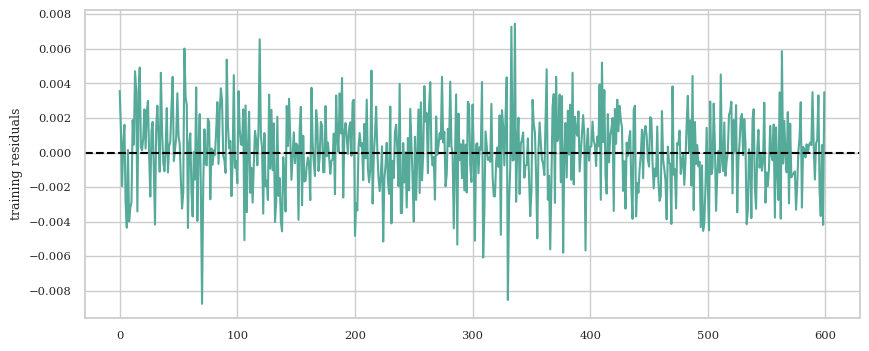

In [69]:
residuals_training = model.resid

plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.ylabel("training residuals")
plt.show()

In [70]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation:", round(autocorrelation, 5), "\n- durbin-watson statistic:", round(durbin_watson, 5))

- autocorrelation: 0.00434 
- durbin-watson statistic: 2.12373


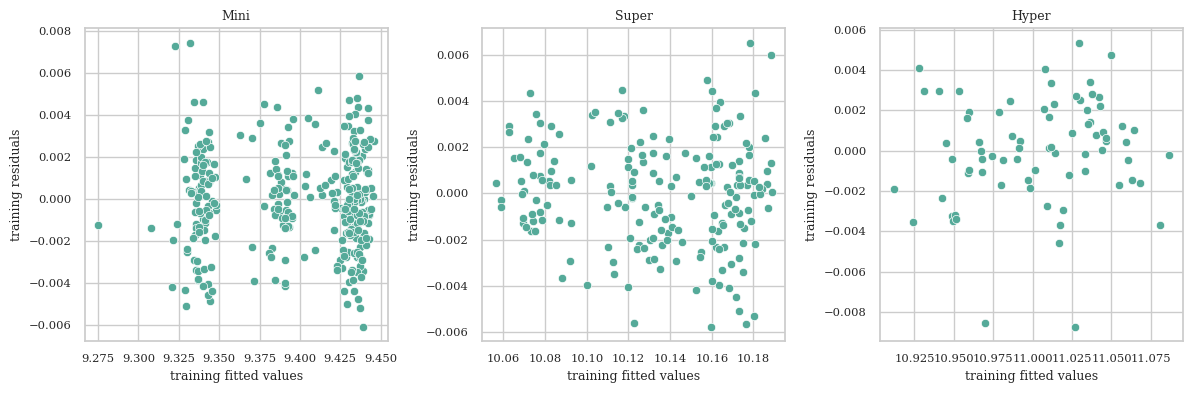

In [71]:
# variance of error terms: residuals vs fitted values
_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
index = 0
ax = ax.flatten()
for index in range(3):
	remove_indexes = list_index[:index] + list_index[(index + 1):]
	X_train_with_intercept_market = X_train_with_intercept.loc[X_train_with_intercept.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	residuals_training_market = residuals_training.loc[residuals_training.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	sns.scatterplot(x = model.predict(X_train_with_intercept_market), y = residuals_training_market, ax = ax[index])
	ax[index].set_title(list_names[index])
	ax[index].set_xlabel("training fitted values")
	ax[index].set_ylabel("training residuals")
	index = index + 1
plt.tight_layout()

In [72]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic:", lzip(name, test)[0][1], "\n- p-value:", lzip(name, test)[1][1])

- lagrange multiplier statistic: 5.211360105798346 
- p-value: 0.6341873181260611


In [73]:
# collinearity
vif = pd.DataFrame()
vif["VIF factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["feature"] = X_train.columns
vif

,VIF factor,feature
0,1.6136e+01,square_feet
1,2.0850e+00,is_mini
2,1.8897e+00,is_super
3,1.5725e+00,is_italy
4,1.5437e+00,is_spain
5,1.4511e+00,competitor_distance
6,1.9946e+01,avg_customers


## Polynomial regressions

il dataset che consideriamo per fare predizione è merged_df senza le variabili ridondanti relative a country e market_type (is_france e is_hyper), che erano derivanti dalla traduzione in variabili booleane. 

in realtà da questo punto in poi ci restringiamo a considerare le best features ottenute con la regressione lineare (con predictor log(y)). <br> 
in teoria andrebbe fatta la feature selection per ogni metodo a partire dal dataset merged_df (da cui come avevamo detto in precedenza sarebbe più corretto rimuovere is_france e is_hyper), però non lo facciamo perchè:
- per evitare di appesantire la relazione;
- abbiamo già appurato che usando solo quelle variabili si riesce ad ottenere un'accuratezza altissima.
  
inoltre standardizziamo i dati perchè gli altri metodi potrebbero essere falsati dalla differenza in termini di ordini di grandezza e di varianza. <br>
da questo momento in poi utilizzeremo X_scaled = standardized(X) come dataframe dei predictors ed y come target series. 

utilizzeremo solo l'mse per confrontare l'accuratezza dei parametri.

In [74]:
# X_scaled
X = merged_df[["square_feet", "is_mini", "is_super", "is_italy", "is_spain", "competitor_distance", "avg_customers"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

# y
y = merged_df[["sales_amount"]]

display(X_scaled, y)

,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,-6.1843e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-6.6040e-01,-4.9556e-01
1,5.1708e-01,-1.0922e+00,1.4142e+00,-6.0302e-01,-5.5579e-01,-6.3095e-01,8.5080e-01
2,8.4377e-01,-1.0922e+00,1.4142e+00,-6.0302e-01,-5.5579e-01,-4.7301e-01,1.0016e-02
3,-7.6073e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,1.7992e+00,-4.1582e-01,-9.5167e-01
4,-8.9071e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-5.7619e-01,-9.4617e-01
...,...,...,...,...,...,...,...
745,-8.3202e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-4.4319e-01,-3.6367e-01
746,-8.9759e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-6.0089e-01,-9.8464e-01
747,3.8624e-01,-1.0922e+00,1.4142e+00,-6.0302e-01,-5.5579e-01,-3.3368e-01,8.2333e-01
748,-9.1162e-01,9.1555e-01,-7.0711e-01,-6.0302e-01,-5.5579e-01,-4.3382e-01,-5.4501e-01


,sales_amount
0,1.2610e+04
1,2.6574e+04
2,2.6124e+04
3,1.1856e+04
4,1.2393e+04
...,...
745,1.2571e+04
746,1.2375e+04
747,2.6405e+04
748,1.2542e+04


In [75]:
# polynomial degree d
for d in range(2, 5):
	model_name = "poly regression (order = " + str(d) + ")"

	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		poly = PolynomialFeatures(d)
		X_train_poly = poly.fit_transform(X_train)
		X_validation_poly = poly.fit_transform(X_validation)
		model = LinearRegression()
		model.fit(X_train_poly, y_train)

		# predict
		y_pred = model.predict(X_validation_poly)
		mse_folds = mse_folds + ((y_validation - y_pred) ** 2).mean().iloc[0]

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds
	cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
	cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05


## Regression splines

nota: non abbiamo knots con problemi di continuità/derivabilità visibili in quanto stiamo imponendo stepfunctions sulla base di variabili categoriali. di conseguenza non possiamo nemmeno porci problemi di continuità.

In [76]:
# polynomial degree d
for d in range(1, 4):
	if d == 1:
		model_name = "linear regression splines"
	else:
		model_name = "poly regression splines (order = " + str(d) + ")"
	

	# dict to store metrics
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		errors_markets = pd.DataFrame()
		
		# list_index = [mini_index, super_index, hyper_index] 
		for market_index in list_index:
			X_train_market = X_train.loc[X_train.index.intersection(market_index)]
			X_validation_market = X_validation.loc[X_validation.index.intersection(market_index)]
			y_train_market = y_train.loc[y_train.index.intersection(market_index)]
			y_validation_market = y_validation.loc[y_validation.index.intersection(market_index)]
			
			# fit
			poly = PolynomialFeatures(d)
			X_train_market_poly = poly.fit_transform(X_train_market)
			X_validation_market_poly = poly.fit_transform(X_validation_market)
			model = LinearRegression()
			model.fit(X_train_market_poly, y_train_market)
			
			# predict
			y_pred_market = model.predict(X_validation_market_poly)
			
			errors_markets = pd.concat([errors_markets, (y_validation_market - y_pred_market) ** 2], ignore_index = True)

		mse_folds = mse_folds + errors_markets.mean().iloc[0]

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds
	cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
	cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04


## Log linear regression splines

In [77]:
model_name = "log linear regression splines"

# dict to store metrics
mse_folds = 0

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
	X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
	y_log_train, y_log_validation = np.log(y).iloc[train_idx], np.log(y).iloc[validation_idx]

	errors_markets = pd.DataFrame()
	
	# list_index = [mini_index, super_index, hyper_index] 
	for market_index in list_index:
		X_train_market = X_train.loc[X_train.index.intersection(market_index)]
		X_validation_market = X_validation.loc[X_validation.index.intersection(market_index)]
		y_log_train_market = y_log_train.loc[y_log_train.index.intersection(market_index)]
		y_log_validation_market = y_log_validation.loc[y_log_validation.index.intersection(market_index)]
		
		# fit
		model = LinearRegression()
		model.fit(X_train_market, y_log_train_market)

		# predict
		y_log_pred_market = model.predict(X_validation_market)
		y_validation_market = pd.DataFrame(merged_df["sales_amount"][y_log_validation_market.index])
		
		errors_markets = pd.concat([errors_markets, (y_validation_market - np.exp(y_log_pred_market)) ** 2], ignore_index = True)

	mse_folds = mse_folds + errors_markets.mean().iloc[0]

# cross-validation MSE
estimated_test_error = mse_folds / number_folds
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03


## Generalized additive model (GAM)

In [78]:
# initialize MSE and lambda
best_lmbd_gam = {
	"MSE": float("inf"),
	"lmbd": float("inf")
}

# different values of lambda (control smoothness)
for lmbd in [2, 5, 10, 100, 1000]:

	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		s_terms = [s(i, lam = lmbd) for i in range(len(X_train.columns))]
		gam = LinearGAM(reduce(lambda x, y: x + y, s_terms))
		gam.fit(X_train, y_train)

		# predict
		y_pred = gam.predict(X_validation)
		# conversion of y_validation to np.array
		y_validation = np.array([element for sublist in y_validation.values for element in sublist])
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	if estimated_test_error < best_lmbd_gam["MSE"]:
		best_lmbd_gam["MSE"] = estimated_test_error
		best_lmbd_gam["lmbd"] = lmbd

model_name = "gam (lambda = " + str(best_lmbd_gam["lmbd"]) + ")"

cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": best_lmbd_gam["MSE"]}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03
gam (lambda = 1000),4.0747e+05


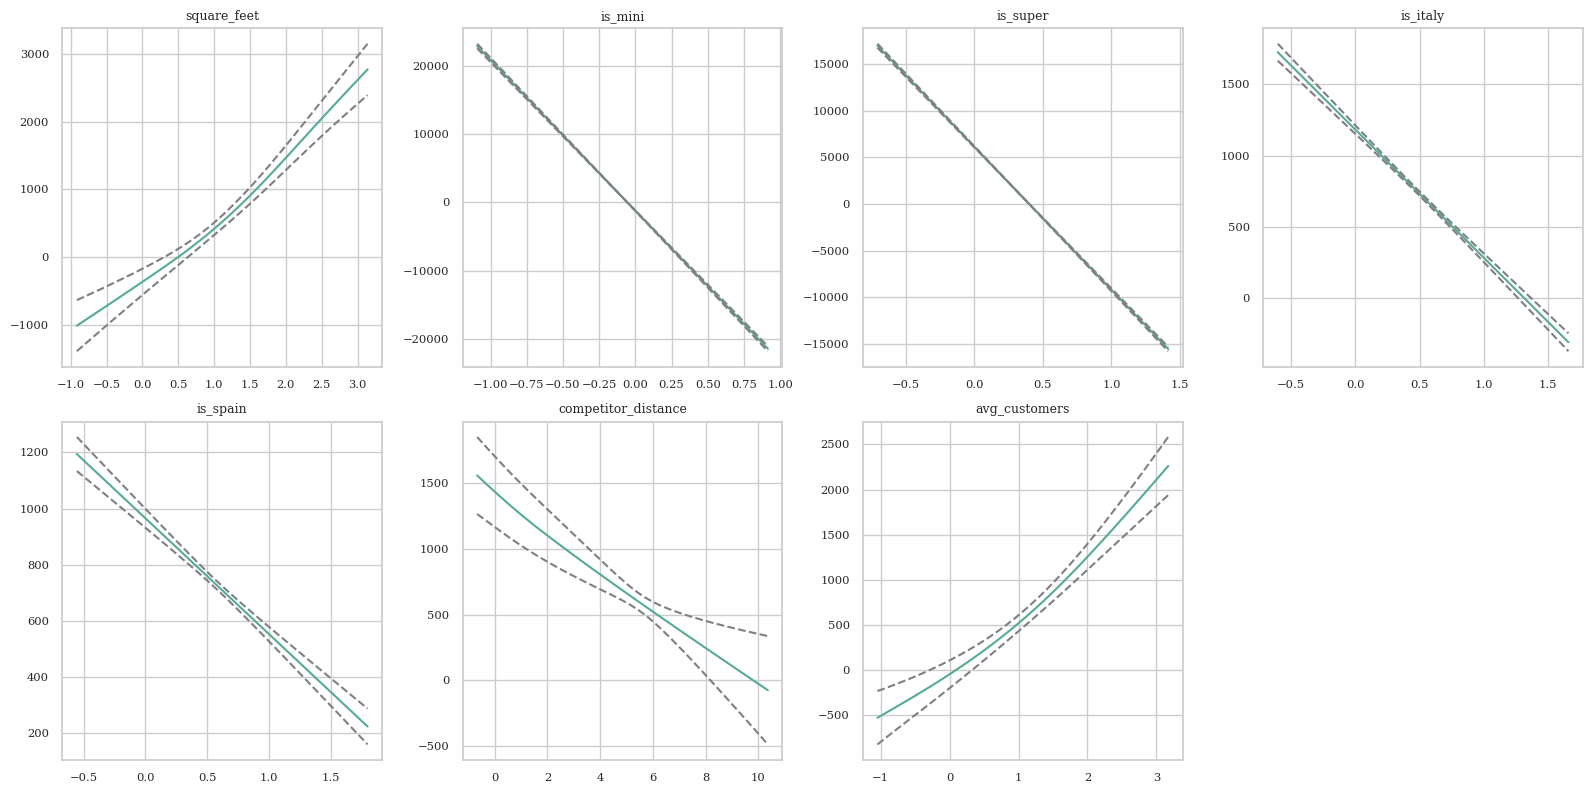

In [79]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8))
index = 0
ax = ax.flatten()
for col_name in list(X.columns):
	XX = gam.generate_X_grid(term = index)
	sns.lineplot(x = XX[:, index], y = gam.partial_dependence(term = index, X = XX), ax = ax[index])
	sns.lineplot(x = XX[:, index], y = gam.partial_dependence(term = index, X = XX, width = .95)[1][:, 0], color = "gray", ls = "--", ax = ax[index])
	sns.lineplot(x = XX[:, index], y = gam.partial_dependence(term = index, X = XX, width = .95)[1][:, 1], color = "gray", ls = "--", ax = ax[index])
	ax[index].set_title(col_name)
	index = index + 1
ax[-1].axis("off")
plt.tight_layout()


## Decision tree (with pruning) (WARNING)

In [80]:
# initialize MSE and lambda
best_alpha = {
	"MSE": float("inf"),
	"alpha": float("inf")
}

# fit a decision tree with all data to derive the alpha values (for tree pruning)
tree = DecisionTreeRegressor(random_state = 2023)
tree.fit(X_scaled, y)
max_depth = tree.get_depth()

# different values of alpha
alphas = []
for node in tree.cost_complexity_pruning_path(X_scaled, y).impurities:
	alphas.append(max(0, node))

for alpha in alphas:

	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		pruned_tree = DecisionTreeRegressor(max_depth = 10, ccp_alpha = alpha, random_state = 2023)
		pruned_tree.fit(X_train, y_train)

		# predict
		y_pred = pruned_tree.predict(X_validation)
		# conversion of y_validation to np.array
		y_validation = np.array([element for sublist in y_validation.values for element in sublist])
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	if estimated_test_error < best_alpha["MSE"]:
		best_alpha["MSE"] = estimated_test_error
		best_alpha["alpha"] = alpha

model_name = "decision tree (with pruning, alpha = " + str("{:.2e}".format(best_alpha["alpha"])) + ")"

cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": best_alpha["MSE"]}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03
gam (lambda = 1000),4.0747e+05


In [81]:
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
import graphviz

final_tree = DecisionTreeRegressor(ccp_alpha = best_alpha["alpha"], random_state = 2023)
final_tree.fit(X_scaled, y)

# tree structure as text
tree_rules = export_text(final_tree, feature_names = X_scaled.columns.tolist())
print("Decision Tree Rules:\n")
print(tree_rules)

# tree as a graph
dot_data = export_graphviz(final_tree, out_file = None, 
	feature_names = X_scaled.columns.tolist(),
	filled=True, rounded = True,
	special_characters = True)
graph = graphviz.Source(dot_data)

Decision Tree Rules:

|--- square_feet <= 1.01
|   |--- square_feet <= -0.34
|   |   |--- is_italy <= 0.53
|   |   |   |--- is_spain <= 0.62
|   |   |   |   |--- competitor_distance <= 1.51
|   |   |   |   |   |--- competitor_distance <= 0.47
|   |   |   |   |   |   |--- avg_customers <= -0.66
|   |   |   |   |   |   |   |--- avg_customers <= -0.89
|   |   |   |   |   |   |   |   |--- square_feet <= -0.85
|   |   |   |   |   |   |   |   |   |--- value: [12393.56]
|   |   |   |   |   |   |   |   |--- square_feet >  -0.85
|   |   |   |   |   |   |   |   |   |--- square_feet <= -0.72
|   |   |   |   |   |   |   |   |   |   |--- value: [12442.28]
|   |   |   |   |   |   |   |   |   |--- square_feet >  -0.72
|   |   |   |   |   |   |   |   |   |   |--- avg_customers <= -0.92
|   |   |   |   |   |   |   |   |   |   |   |--- value: [12467.74]
|   |   |   |   |   |   |   |   |   |   |--- avg_customers >  -0.92
|   |   |   |   |   |   |   |   |   |   |   |--- value: [12543.17]
|   |   |   |   |

## Random forests

In [82]:
# initialize MSE
best_params = {
	"MSE": float("inf"),
	"params": [-1, -1]
}

# initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

# parameters setting: [n_estimators, min_samples_split]
list_parameters = [[100, 2], [500, 2], [1000, 2]]
for params in list_parameters:
	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		model = RandomForestRegressor(n_estimators = params[0], min_samples_split = params[1], max_features = "sqrt", random_state = 2023)
		y_train = np.array([element for sublist in y_train.values for element in sublist])
		model.fit(X_train, y_train)

		# predict
		y_pred = model.predict(X_validation)
		# conversion of y_validation to np.array
		y_validation = np.array([element for sublist in y_validation.values for element in sublist])
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds
	if estimated_test_error < best_params["MSE"]:
		best_params["MSE"] = estimated_test_error
		best_params["params"] = params

model_name = "random forests ([n_estimators, min_samples_split] = " + str(best_params["params"]) + ")"
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": best_params["MSE"]}])])
cv_mse = cv_mse.rename(index = {0: model_name})
cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03
gam (lambda = 1000),4.0747e+05


## Gradient boosting

In [83]:
# initialize MSE and lambda
best_lmbd_gam = {
	"MSE": float("inf"),
	"lmbd": float("inf")
}

# different values of lambda (control smoothness)
for lmbd in [0.001, 0.01, 0.1, 0.5]:

	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)
	
	# store mse
	mse_folds = 0

	# run k-fold cv
	for train_idx, validation_idx in kf.split(X_scaled):
		X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
		y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

		# fit
		model = GradientBoostingRegressor(n_estimators = 1000, max_leaf_nodes = 32, learning_rate = lmbd, random_state = 2023)
		y_train = np.array([element for sublist in y_train.values for element in sublist])
		model.fit(X_train, y_train)

		# predict
		y_pred = model.predict(X_validation)
		# conversion of y_validation to np.array
		y_validation = np.array([element for sublist in y_validation.values for element in sublist])
		mse_folds = mse_folds + np.mean((y_validation - y_pred) ** 2)

	# cross-validation MSE
	estimated_test_error = mse_folds / number_folds

	# check if the estimated_test_error has decreased
	if estimated_test_error < best_lmbd_gam["MSE"]:
		best_lmbd_gam["MSE"] = estimated_test_error
		best_lmbd_gam["lmbd"] = lmbd

model_name = "gradient boosting (lambda = " + str(best_lmbd_gam["lmbd"]) + ")"

cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": best_lmbd_gam["MSE"]}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03
gam (lambda = 1000),4.0747e+05


## Support vector machine (SVM)

In [84]:
y = y.iloc[:, 0]

parameters = {
    "C": np.linspace(1, 100, 10).tolist(), 
    "kernel": ["poly"],
    "gamma": ["scale", "auto"] + np.linspace(0.01, 1, 10).tolist(),
}

# set the parameters
svm = SVR()
grid_search = GridSearchCV(svm, parameters, cv = 5)
grid_search.fit(X_scaled, y)
best_params = grid_search.best_params_

# initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

model_name = "svm ([C, gamma, ker] = " + str(list(best_params.values())) + ")"

# store mse
mse_folds = 0

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
	X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
	y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # fit 
	model = SVR(C = best_params["C"], kernel = best_params["kernel"], gamma = best_params["gamma"])
	model.fit(X_train, y_train)

	# predict
	y_pred = model.predict(X_validation)

	mse_folds = mse_folds + ((y_validation - y_pred) ** 2).mean()

# cross-validation MSE
estimated_test_error = mse_folds / number_folds
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
cv_mse = cv_mse.rename(index = {0: model_name})

y = merged_df[["sales_amount"]]

cv_mse

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03
gam (lambda = 1000),4.0747e+05


## Neural Network (NN)

In [85]:
# set device (gpu or cpu)
gpu_flag = False
if gpu_flag:
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print("using device " + str(device) + ": ", end = "")
	if device.type == "cuda":
		print(torch.cuda.get_device_name(0), end = "")
		print(" (cuda version " + torch.version.cuda + ")")
else:
	device = torch.device("cpu")
	print("using device " + str(device))

using device cpu


fold 1
	epoch [20/200]	/ (training) loss: 3354.8117675781
	epoch [40/200]	/ (training) loss: 2459.5344238281
	epoch [60/200]	/ (training) loss: 2664.7983398438
	epoch [80/200]	/ (training) loss: 2852.9516601562
	epoch [100/200]	/ (training) loss: 3049.6689453125
	epoch [120/200]	/ (training) loss: 3064.6362304688
	epoch [140/200]	/ (training) loss: 3100.3659667969
	epoch [160/200]	/ (training) loss: 3136.5378417969
	epoch [180/200]	/ (training) loss: 3256.6396484375
	epoch [200/200]	/ (training) loss: 3044.6306152344
fold 2
	epoch [20/200]	/ (training) loss: 2350.5366210938
	epoch [40/200]	/ (training) loss: 787.7608642578
	epoch [60/200]	/ (training) loss: 513.3572998047
	epoch [80/200]	/ (training) loss: 555.6564331055
	epoch [100/200]	/ (training) loss: 692.8139648438
	epoch [120/200]	/ (training) loss: 823.5423583984
	epoch [140/200]	/ (training) loss: 966.1511840820
	epoch [160/200]	/ (training) loss: 1083.6156005859
	epoch [180/200]	/ (training) loss: 1316.2822265625
	epoch [200/

,MSE
linear regression,4.1357e+05
log linear regression,4.5784e+03
poly regression (order = 2),4.9262e+03
poly regression (order = 3),7.6183e+03
poly regression (order = 4),5.1571e+05
linear regression splines,4.8095e+03
poly regression splines (order = 2),6.2447e+03
poly regression splines (order = 3),6.6924e+04
log linear regression splines,4.6053e+03
gam (lambda = 1000),4.0747e+05


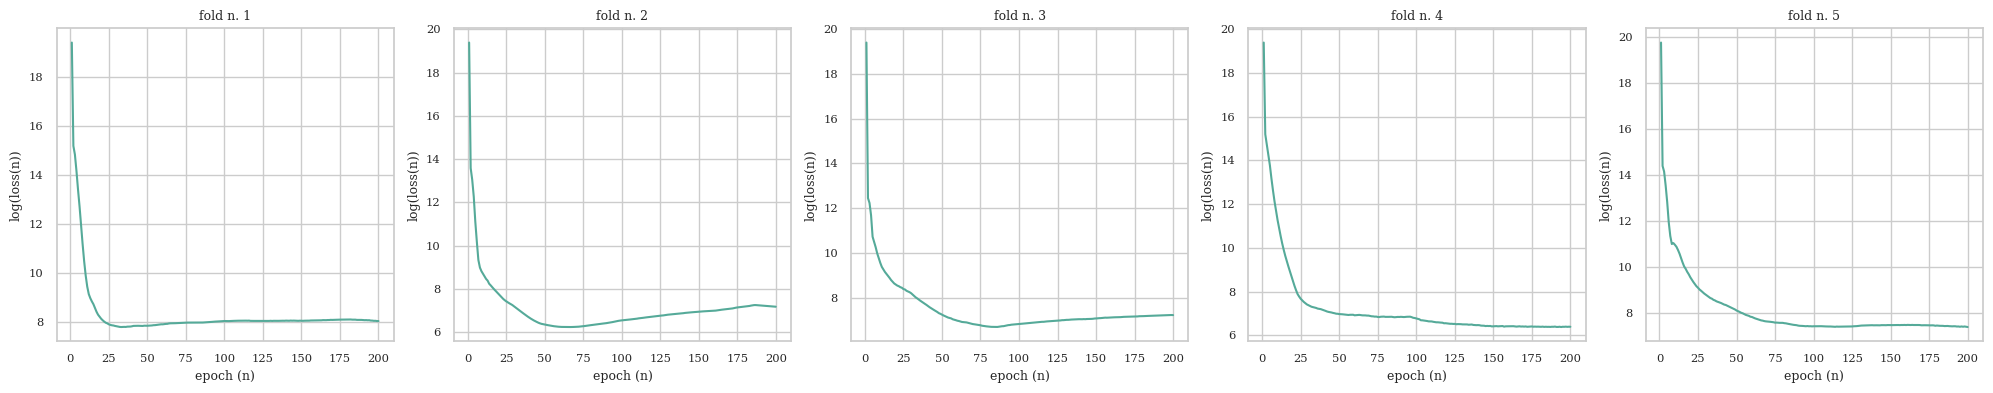

In [86]:
torch.manual_seed(2023)

# predictors = X_scaled_nn, target = y_nn
X = merged_df[['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers']]
X_scaled_nn = scaler.fit_transform(X)
y_nn = y.to_numpy().reshape(-1, 1)

# model
input_size = X_train.shape[1]
hidden_sizes = [100, 100]
output_size = 1
def nn_model(input_size, hidden_sizes, output_size):
	layers = []
	for i in range(len(hidden_sizes)):
		if i == 0:
			layers.append(nn.Linear(input_size, hidden_sizes[i]))
		else:
			layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
		layers.append(nn.ReLU())
	layers.append(nn.Linear(hidden_sizes[-1], output_size))
	return nn.Sequential(*layers)

# learning parameters
learning_rate = 0.0000001
num_epochs = 200
batch_size = 5
# loss
criterion = nn.MSELoss()

# initialize kfold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits = number_folds, shuffle = True, random_state = 2023)

model_name = "nn (" + str(len(hidden_sizes)) + "hidden layers, ReLU)"

# store mse
mse_folds = 0

# run k-fold cv
fold_counter = 0
_, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (20, 4))
ax = ax.flatten()

for train_idx, validation_idx in kf.split(X_scaled_nn):
	fold_counter = fold_counter + 1
	print("fold " + str(fold_counter))
	X_train, X_validation = X_scaled_nn[train_idx, :], X_scaled_nn[validation_idx, :]
	y_train, y_validation = y_nn[train_idx], y_nn[validation_idx]
	X_train_tensor, X_val_tensor = torch.FloatTensor(X_train).to(device), torch.FloatTensor(X_validation).to(device)
	y_train_tensor, y_val_tensor = torch.FloatTensor(y_train).to(device), torch.FloatTensor(y_validation).to(device)
	
	# model
	model = nn_model(input_size, hidden_sizes, output_size)
	model = model.to(device)
	# optimizer
	optimizer = optim.SGD(model.parameters(), lr = learning_rate)

	cv_losses = []
	# fit (during epochs)
	for epoch in range(num_epochs):
		for batch_start in range(0, X_train_tensor.size(0), batch_size):
			# get batch
			X_batch = X_train_tensor[batch_start:(batch_start + batch_size)]
			y_batch = y_train_tensor[batch_start:(batch_start + batch_size)]
			# forward pass
			outputs = model.forward(X_batch)
			loss = criterion(outputs, y_batch)
			# backward pass and optimization (gradient descent)
			optimizer.zero_grad() 
			loss.backward()
			optimizer.step()
		# loading (every 10 epochs)
		if (epoch + 1) % 20 == 0:
			print("\tepoch [" + str(epoch + 1) + "/" + str(num_epochs) + "]\t/ (training) loss:", "{:.10f}".format(loss.item()))
		cv_losses.append(loss.item())

	# plot loss
	sns.lineplot(x = range(1, num_epochs + 1), y = np.log(cv_losses), ax = ax[fold_counter - 1])
	ax[fold_counter - 1].set_title("fold n. " + str(fold_counter))
	ax[fold_counter - 1].set_xlabel("epoch (n)")
	ax[fold_counter - 1].set_ylabel("log(loss(n))")

	# predict
	with torch.no_grad():
		model.eval()
		y_pred = model.forward(X_val_tensor)
		valid_loss = criterion(y_pred, y_val_tensor)
		mse_folds = mse_folds + valid_loss.item()

plt.tight_layout()

# cross-validation MSE
estimated_test_error = mse_folds / number_folds
cv_mse = pd.concat([cv_mse, pd.DataFrame([{"MSE": estimated_test_error}])])
cv_mse = cv_mse.rename(index = {0: model_name})

cv_mse

## Solution

In [87]:
options_mini = pd.DataFrame(
	np.array([
		[1850, 1, 0, 0, 1, 4500, 190], 
		[2100, 1, 0, 0, 0, 12850, 215], 
		[1920, 1, 0, 1, 0, 1450, 220]]), 
	columns = ['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers'])

options_super = pd.DataFrame(
	np.array([
		[5580, 0, 1, 0, 1, 580, 420], 
		[5120, 0, 1, 0, 0, 2560, 390], 
		[4970, 0, 1, 1, 0, 3520, 410]]), 
	columns = ['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers'])

options_hyper = pd.DataFrame(
	np.array([
		[10560, 0, 0, 0, 1, 8940, 860], 
		[12570, 0, 0, 0, 0, 7580, 880], 
		[11980, 0, 0, 1, 0, 11560, 790]]), 
	columns = ['square_feet', 'is_mini', 'is_super', 'is_italy', 'is_spain', 'competitor_distance', 'avg_customers'])

display(options_mini)
display(options_super)
display(options_hyper)

,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,1850,1,0,0,1,4500,190
1,2100,1,0,0,0,12850,215
2,1920,1,0,1,0,1450,220


,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,5580,0,1,0,1,580,420
1,5120,0,1,0,0,2560,390
2,4970,0,1,1,0,3520,410


,square_feet,is_mini,is_super,is_italy,is_spain,competitor_distance,avg_customers
0,10560,0,0,0,1,8940,860
1,12570,0,0,0,0,7580,880
2,11980,0,0,1,0,11560,790
